In [2]:
from astropy.table import *
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches as patches
import matplotlib.cm as cm

from scipy.stats import chi2, binned_statistic
from astropy.cosmology import Planck13
import pickle
from numpy import random
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit


plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [21]:
# color-color boundary
def boundary_basic(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)


def boundary_4d(color1, ic_1, ic_2, slope, z_factor, M_factor, z, M):
    nuv_1 = ic_1
    nuv_2 = (slope+z_factor*z+M_factor*M)*(color1 + ic_2)
    return np.maximum(nuv_1, nuv_2)


def boundary_3d(color1, ic_1, ic_2, slope, M_factor, M):
    nuv_1 = ic_1
    nuv_2 = (slope+M_factor*M)*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [3]:
# the function to add photometric flags
# for a certain band, good flag requirements are detected + low uncertainty

def add_photo_flag(cat,c20_zname='lp_zPDF',c20_massname='lp_mass_med'):
    cat_matched = cat
    cat_matched = cat_matched[cat_matched[c20_zname]>0]
    cat_matched = cat_matched[cat_matched[c20_massname]>0]
    
    max_phot_err = 0.2
    cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err*2) )| \
             ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err*2) )
    cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err*2) ) 
    cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err*2) )
    cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
    cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
    cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
    flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
    
    cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
    cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
    cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
    cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
    flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)
    
    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
     
    flag_list = [flag_optical,flag_nir,flag_irac]
    flag_name_list = ['flag_optical','flag_nir','flag_irac']
        
    if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
        print('lengths do not match')
        return None
    else:
        col_flag_optical = Column(name='flag_optical', data=flag_optical)
        col_flag_nir = Column(name='flag_nir', data=flag_nir)
        col_flag_irac = Column(name='flag_irac', data=flag_irac)
        if 'flag_optical' in cat_matched.keys():
            cat_matched.remove_column('flag_optical')
        if 'flag_nir' in cat_matched.keys():
            cat_matched.remove_column('flag_nir')
        if 'flag_irac' in cat_matched.keys():
            cat_matched.remove_column('flag_irac')
            
        cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac])
        return cat_matched

#### Load in my COSMOS catalog
COSMOS catalog with no detection upper limit, with N(z) prior\
central cosmos only

In [2]:
cat_cosmos = Table.read('/Volumes/LejaySSD/pcat_lephare_masses/COSMOS_galaxies.fits')

# trim catalog to only central COSMOS
cat_cosmos = cat_cosmos[cat_cosmos['RA'] > 149.65]
cat_cosmos = cat_cosmos[cat_cosmos['RA'] < 150.65]
cat_cosmos = cat_cosmos[cat_cosmos['DEC'] > 1.7]
cat_cosmos = cat_cosmos[cat_cosmos['DEC'] < 2.7]
cat_cosmos.write('/Volumes/LejaySSD/pcat_lephare_masses/COSMOS_galaxies_central.fits',overwrite=True)
print(len(cat_cosmos))

265289


#### Match with COSMOS2020 (C20)
V2.2 Classic+LePhare

keys in the trimmed C20 catalog: ID, RA/DEC, photometry (MAG_AUTOs and error), lephare redshift/mass/rest-frame-color/ssfr

In [16]:
cat_c20_classic  = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.2_trim.fits')
cat_c20_farmer  = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits')
print(len(cat_c20_classic),len(cat_c20_farmer))

1720700 964506


##### add Weaver+2020 NUVrJ selection (lephare)

$NUV-r>3(r-J)+1$\
$NUV-r>3.1$

In [17]:
# lp_MNUV, lp_MR, lp_MJ
# 0==q, 1==sf
c20_name = 'CLASSIC' # or 'FARMER'
if c20_name == 'CLASSIC':
    cat_c20 = cat_c20_classic
else:
    cat_c20 = cat_c20_farmer
    
cond1 = (cat_c20['lp_MNUV'] - cat_c20['lp_MR']) < (3*(cat_c20['lp_MR'] - cat_c20['lp_MJ']) + 1)
cond2 = (cat_c20['lp_MNUV'] - cat_c20['lp_MR']) < 3.1
CLASS = (cond1|cond2).astype(int)

class_col = Column(data=CLASS, name='CLASS')
if 'CLASS' in cat_c20.keys():
    cat_c20.remove_column('CLASS')
cat_c20.add_column(class_col)
cat_c20.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_'+c20_name+'_R1_v2.2_trim.fits', overwrite=True)

##### add Williams+2009 UVJ selection (eazy)

$U-V>0.88(V-J)+0.69$\
$U-V>1.3$\
$V-J<1.6$

In [18]:
# ez_restU', 'ez_restV', 'ez_restJ'
# 0==q, 1==sf
c20_name = 'CLASSIC' # or 'FARMER'
if c20_name == 'CLASSIC':
    cat_c20 = cat_c20_classic
else:
    cat_c20 = cat_c20_farmer
    
ez_U = 2.5*(23-np.log10(cat_c20['ez_restU']/1e6))-48.6
ez_V = 2.5*(23-np.log10(cat_c20['ez_restV']/1e6))-48.6
ez_J = 2.5*(23-np.log10(cat_c20['ez_restJ']/1e6))-48.6

cond1 = (ez_U - ez_V) < (0.88*(ez_V - ez_J) + 0.69)
cond2 = (ez_U - ez_V) < 1.3
cond3 = (ez_V - ez_J) > 1.6
CLASS = (cond1|cond2|cond3).astype(int)

class_col = Column(data=CLASS, name='CLASS_UVJ')
if 'CLASS_UVJ' in cat_c20.keys():
    cat_c20.remove_column('CLASS_UVJ')
cat_c20.add_column(class_col)
cat_c20.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_'+c20_name+'_R1_v2.2_trim.fits', overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


#### match between two COSMOS catalogs

In [30]:
# see C20_photoz_mass_check.ipynb for matching !!
#!!!!!!!!!

In [20]:
# add flag_photoz 
# 0=bad-z, 1=good-z within classic, 2=good-z, negative=not matched

factor = 0.15
lp1_lp2_cond = abs(cat_matched['lp_zPDF_classic'] - cat_matched['lp_zPDF_farmer']) < factor*(1+cat_matched['lp_zPDF_classic'])
lp1_ez1_cond = abs(cat_matched['lp_zPDF_classic'] - cat_matched['ez_z500_classic']) < factor*(1+cat_matched['lp_zPDF_classic'])
lp1_ez2_cond = abs(cat_matched['lp_zPDF_classic'] - cat_matched['ez_z500_farmer']) < factor*(1+cat_matched['lp_zPDF_classic'])
lp2_ez1_cond = abs(cat_matched['lp_zPDF_farmer'] - cat_matched['ez_z500_classic']) < factor*(1+cat_matched['lp_zPDF_farmer'])
lp2_ez2_cond = abs(cat_matched['lp_zPDF_farmer'] - cat_matched['ez_z500_farmer']) < factor*(1+cat_matched['lp_zPDF_farmer'])
ez1_ez2_cond = abs(cat_matched['ez_z500_classic'] - cat_matched['ez_z500_farmer']) < factor*(1+cat_matched['ez_z500_classic'])

flag_matched = np.array(np.isnan(cat_matched['lp_zPDF_farmer'])).astype(int)*-99
flag_goodz = np.array(lp1_lp2_cond*lp1_ez1_cond*lp1_ez2_cond*lp2_ez1_cond*lp2_ez2_cond*ez1_ez2_cond).astype(int)
flag_goodz_classic = np.array(lp1_ez1_cond)

flag_photoz_c20 = flag_matched + flag_goodz + flag_goodz_classic # 0=bad-z, 1=good-z within classic, 2=good-z, negative=not matched
flag_photoz_col = Column(name='flag_photoz',data=flag_photoz_c20)

if 'flag_photoz' in cat_matched.keys():
    cat_matched.remove_column('flag_photoz')
cat_matched.add_column(flag_photoz_col)
cat_matched.write(combined_cat_name, overwrite=True)

# add the column into classical catalog
if 'flag_photoz' in cat_c20_classic.keys():
    cat_c20_classic.remove_column('flag_photoz')
cat_c20_classic.add_column(flag_photoz_col)
cat_c20_classic.write(cat_c20_classic_name, overwrite=True)

#### match with C20 (keep all from C20)
small area test on galaxy number counts

In [5]:
#####
# area comparison

########
# region 1
# ra_min = 149.9
# ra_max = 150.0
# dec_min = 2.3
# dec_max = 2.5

# region 2
# ra_min = 150.3
# ra_max = 150.7
# dec_min = 2.35
# dec_max = 2.85

# region 3
# ra_min = 149.4
# ra_max = 149.8
# dec_min = 1.6
# dec_max = 1.8

# region 4
ra_min = 149.8
ra_max = 150.1
dec_min = 2.2
dec_max = 2.6

d_ra = ra_max-ra_min
dec_1 = dec_min
dec_2 = dec_max

# COSMOS2020 area 
area_c20_cosmos = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('C20_masks/COSMOS2020_random_point_test.fits')
cat_random = cat_random[cat_random['ra'] > ra_min]
cat_random = cat_random[cat_random['ra'] < ra_max]
cat_random = cat_random[cat_random['dec'] > dec_min]
cat_random = cat_random[cat_random['dec'] < dec_max]
cat_random_nomask = cat_random[np.logical_and(cat_random['mask_hsc']==1, cat_random['inside_hsc']==1) ]
area_c20_cosmos = area_c20_cosmos * len(cat_random_nomask)/len(cat_random)
print("C20 COSMOS", area_c20_cosmos, round(np.mean(cat_random_nomask['ra']),3), round(np.mean(cat_random_nomask['dec']),3))

# my COSMOS area 
area_my_cosmos = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('C20_masks/COSMOS_deep_random_point_test.fits')
cat_random = cat_random[cat_random['ra'] > ra_min]
cat_random = cat_random[cat_random['ra'] < ra_max]
cat_random = cat_random[cat_random['dec'] > dec_min]
cat_random = cat_random[cat_random['dec'] < dec_max]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_my_cosmos = area_my_cosmos * len(cat_random_nomask)/len(cat_random)
print("my COSMOS", area_my_cosmos, round(np.mean(cat_random_nomask['ra']),3), round(np.mean(cat_random_nomask['dec']),3))

print('area ratio', round(area_my_cosmos/area_c20_cosmos,4))

C20 COSMOS 0.10778970801336782 149.902 2.425
my COSMOS 0.1105050785617615 149.902 2.425
area ratio 1.0252


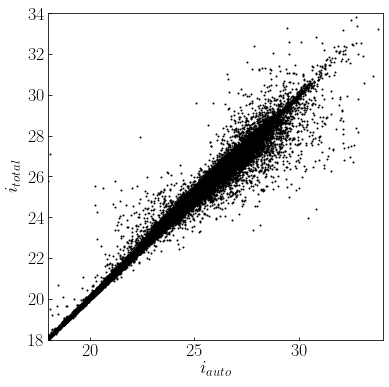

In [24]:
# auto mag and aper2+total_off2 mag (in CLASSIC catalog)
cat_C20_classic = Table.read('/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.2_trim.fits')
cat_C20_classic = cat_C20_classic[cat_C20_classic['lp_type']==0]
cat_C20_classic = cat_C20_classic[cat_C20_classic['FLAG_COMBINED']==0]

fig, axs = plt.subplots(1, 1, figsize = (6, 6))
plt.scatter(cat_C20_classic['HSC_i_MAG_AUTO'],cat_C20_classic['HSC_i_MAG_APER2']+cat_C20_classic['total_off2'],s=1,color='k')
plt.xlim([18,34])
plt.ylim([18,34])
plt.xlabel('$i_{auto}$',fontsize=19)
plt.ylabel('$i_{total}$',fontsize=19)
plt.show()

In [11]:
# fraction of galaxies in C20 FARMER with no i mag
cat_C20_farmer = Table.read('/Users/lejay/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits')
cat_C20_farmer = cat_C20_farmer[cat_C20_farmer['lp_type']==0]
cat_C20_farmer = cat_C20_farmer[cat_C20_farmer['FLAG_COMBINED']==0]

all_gal = len(cat_C20_farmer)
with_i_gal = len(cat_C20_farmer[cat_C20_farmer['HSC_i_MAG']>0])
print(all_gal,with_i_gal,'i-mag fraction',round(with_i_gal/all_gal,4))

709087 701516 i-mag fraction 0.9893


In [9]:
band = 'i'
mag_cut = 26

cat_C20_farmer = Table.read('/Users/lejay/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits')
cat_C20_farmer = cat_C20_farmer[(cat_C20_farmer['HSC_'+band+'_MAG']<mag_cut) & (cat_C20_farmer['HSC_'+band+'_MAG']>16)]
cat_C20_farmer = cat_C20_farmer[cat_C20_farmer['lp_type']==0]
cat_C20_farmer = cat_C20_farmer[cat_C20_farmer['FLAG_COMBINED']==0]

cat_C20_classic = Table.read('/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.2_trim.fits')
cat_C20_classic = cat_C20_classic[(cat_C20_classic['HSC_'+band+'_MAG_APER2']+cat_C20_classic['total_off2']<mag_cut) & (cat_C20_classic['HSC_'+band+'_MAG_APER2']+cat_C20_classic['total_off2']>16)]
cat_C20_classic = cat_C20_classic[cat_C20_classic['lp_type']==0]
cat_C20_classic = cat_C20_classic[cat_C20_classic['FLAG_COMBINED']==0]

cat_mycosmos_type = 'after_sed'
# cat_mycosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits'
cat_mycosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits'
cat_mycosmos = Table.read(cat_mycosmos_name)

# cat_mycosmos_type = 'before_sed'
# cat_mycosmos_name = '/Users/lejay/phosphorus_catalogs/p_cats_v211221/COSMOS_deep_pcat_mags_gals_CH1_CH2_extinction_corrected.fits'
# cat_mycosmos = Table.read(cat_mycosmos_name)

# cat_mycosmos = cat_mycosmos[cat_mycosmos['inside_u']==True]
# cat_mycosmos = cat_mycosmos[cat_mycosmos['inside_hsc']==True]
cat_mycosmos = cat_mycosmos[(cat_mycosmos[band]<mag_cut) & (cat_mycosmos[band]>16)]
cat_mycosmos = cat_mycosmos[cat_mycosmos['snr_i']>1.5]
cat_mycosmos = cat_mycosmos[cat_mycosmos['snr_'+band]>3]
cat_mycosmos = cat_mycosmos[cat_mycosmos['isCompact']==False]
cat_mycosmos = cat_mycosmos[np.logical_or(cat_mycosmos['isCompact']==False,cat_mycosmos['i']>24)]
cat_mycosmos = cat_mycosmos[cat_mycosmos['ZPHOT_G']>0]

print('length of catalogs:',len(cat_mycosmos),len(cat_C20_farmer),len(cat_C20_classic))

ra_name = 'RA'
dec_name = 'DEC'
cat_test_mycosmos = cat_mycosmos[cat_mycosmos[ra_name] > ra_min]
cat_test_mycosmos = cat_test_mycosmos[cat_test_mycosmos[ra_name] < ra_max]
cat_test_mycosmos = cat_test_mycosmos[cat_test_mycosmos[dec_name] > dec_min]
cat_test_mycosmos = cat_test_mycosmos[cat_test_mycosmos[dec_name] < dec_max]

ra_name = 'ALPHA_J2000'
dec_name = 'DELTA_J2000'
cat_test_c20_farmer = cat_C20_farmer[cat_C20_farmer[ra_name] > ra_min]
cat_test_c20_farmer = cat_test_c20_farmer[cat_test_c20_farmer[ra_name] < ra_max]
cat_test_c20_farmer = cat_test_c20_farmer[cat_test_c20_farmer[dec_name] > dec_min]
cat_test_c20_farmer = cat_test_c20_farmer[cat_test_c20_farmer[dec_name] < dec_max]

ra_name = 'ALPHA_J2000'
dec_name = 'DELTA_J2000'
cat_test_c20_classic = cat_C20_classic[cat_C20_classic[ra_name] > ra_min]
cat_test_c20_classic = cat_test_c20_classic[cat_test_c20_classic[ra_name] < ra_max]
cat_test_c20_classic = cat_test_c20_classic[cat_test_c20_classic[dec_name] > dec_min]
cat_test_c20_classic = cat_test_c20_classic[cat_test_c20_classic[dec_name] < dec_max]

cat_test_mycosmos.write('/Users/lejay/phosphorus_catalogs/p_cats_v211221/COSMOS_deep_pcat_mags_gals_small_area_test.fits',overwrite=True)
cat_test_c20_farmer.write('/Users/lejay/COSMOS2020/C20_farmer_small_area_test.fits',overwrite=True)
cat_test_c20_classic.write('/Users/lejay/COSMOS2020/C20_classic_small_area_test.fits',overwrite=True)
print(len(cat_test_mycosmos),len(cat_test_c20_farmer),len(cat_test_c20_classic),round(len(cat_test_mycosmos)/len(cat_test_c20_farmer),3))


length of catalogs: 210801 331295 386592
33940 26615 31317 1.275


In [11]:
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

for i in range(len(z_mins)):
    if cat_mycosmos_type == 'after_sed':
        z_min = z_mins[i]
        z_max = z_maxs[i]
        print('')
        print(z_min,z_max)
        cat_test_mycosmos_z = cat_test_mycosmos[(cat_test_mycosmos['Z_COMBINE']>z_min) & (cat_test_mycosmos['Z_COMBINE']<z_max)]
        cat_test_c20_z = cat_test_c20_farmer[(cat_test_c20_farmer['lp_zPDF']>z_min) & (cat_test_c20_farmer['lp_zPDF']<z_max)]
        print('before mass cut',len(cat_test_mycosmos_z),len(cat_test_c20_z),round(len(cat_test_mycosmos_z)/len(cat_test_c20_z),3))
        
        m_min = 9
        m_max = 10
        cat_test_mycosmos_zm = cat_test_mycosmos_z[(cat_test_mycosmos_z['MASS_MED_massrun']>m_min) & (cat_test_mycosmos_z['MASS_MED_massrun']<m_max)]
        cat_test_c20_zm = cat_test_c20_z[(cat_test_c20_z['lp_mass_med']>m_min) & (cat_test_c20_z['lp_mass_med']<m_max)]
        print('after mass cut',len(cat_test_mycosmos_zm),len(cat_test_c20_zm),round(len(cat_test_mycosmos_zm)/len(cat_test_c20_zm),3))
    else:
        pass


0.2 0.5
before mass cut 4585 3707 1.237
after mass cut 600 530 1.132

0.5 0.8
before mass cut 5920 4912 1.205
after mass cut 1486 1243 1.195

0.8 1.1
before mass cut 5817 4590 1.267
after mass cut 1935 1600 1.209

1.1 1.5
before mass cut 4495 4044 1.112
after mass cut 2017 1874 1.076


##### match catalogs

In [21]:
cat_mycosmos_name = '/Users/lejay/phosphorus_catalogs/p_cats_v211221/COSMOS_deep_pcat_mags_gals_small_area_test.fits'
cat_c20_farmer_name = '/Users/lejay/COSMOS2020/C20_farmer_small_area_test.fits'
cat_c20_classic_name = '/Users/lejay/COSMOS2020/C20_classic_small_area_test.fits'
combined_cat_name = '/Users/lejay/phosphorus_catalogs/COSMOS_galaxies_small_area_test.fits'

col_list_farmer = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG FLAG_COMBINED lp_type lp_zPDF lp_mass_med'"
col_list_classic = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG_AUTO HSC_i_MAG_APER2 total_off2 lp_type FLAG_COMBINED lp_zPDF lp_mass_med'"
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
   in1='+cat_mycosmos_name+' values1="RA DEC" \
   in2='+cat_c20_farmer_name+' values2="ALPHA_J2000 DELTA_J2000" \
   in3='+cat_c20_classic_name+' values3="ALPHA_J2000 DELTA_J2000" \
   out='+ combined_cat_name+' icmd2="keepcols '+col_list_farmer+'" '+' icmd3="keepcols '+col_list_classic+'" join1=always'
os.system(cmd)

cat_matched = Table.read(combined_cat_name)
# remove unnecessary columns
cat_matched = Table.read(combined_cat_name)

cat_matched.remove_columns(['ALPHA_J2000_2','DELTA_J2000_2','ALPHA_J2000_3','DELTA_J2000_3'])
for keyname in cat_matched.keys():
    if '_2' in keyname:
        cat_matched.rename_column(keyname, keyname.replace('_2','_farmer'))
    elif '_3' in keyname:
        cat_matched.rename_column(keyname, keyname.replace('_3','_classic'))

# print(cat_matched.info)
# cat_matched.rename_column('HSC_i_MAG', 'HSC_i_MAG_farmer')
cat_matched.remove_columns(['tract','patch'])     
cat_matched.write(combined_cat_name, overwrite=True)

# match with v9 catalog
v9_cat_name = '/Volumes/LejaySSD/v9_cats/COSMOS_deep_v9.fits'
col_list_v9 = "'ID RA DEC u uS g r i z ZPHOT MASS_MED'"
cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0"\
   in1='+combined_cat_name + ' values1="RA DEC" \
   in2='+v9_cat_name+' values2="RA DEC"  join=all1\
   out='+ combined_cat_name+' icmd2="keepcols '+col_list_v9+'"'
os.system(cmd)
cat_matched = Table.read(combined_cat_name)
cat_matched.remove_columns(['RA_2','DEC_2'])
cat_matched.rename_column('RA_1','RA')
cat_matched.rename_column('DEC_1','DEC')
for keyname in cat_matched.keys():
    if 'Separation' in keyname:
        cat_matched.remove_column(keyname)
        
for keyname in cat_matched.keys():
    if '_1' in keyname:
        cat_matched.rename_column(keyname, keyname.replace('_1',''))
    elif '_2' in keyname:
        cat_matched.rename_column(keyname, keyname.replace('_2','_v9'))
        
cat_matched.write(combined_cat_name, overwrite=True)   

In [ ]:
# match hscpipe flux catalog to get aperture photometry
pcat_name = '/Users/lejay/phosphorus_catalogs/p_cats_v211221/COSMOS-HSCpipe-Phosphoros_updated_211221.fits'
col_list_hscpipe = "'RA DEC FLUX_APER_3_HSC-I FLUX_CMODEL_HSC-I'"
cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0"\
   in1='+combined_cat_name + ' values1="RA DEC" \
   in2='+pcat_name+' values2="RA DEC"  join=all1\
   out='+ combined_cat_name+' icmd2="keepcols '+col_list_hscpipe+'"'
os.system(cmd)

cat_matched = Table.read(combined_cat_name)
cat_matched.remove_columns(['RA_2','DEC_2'])
cat_matched.rename_column('RA_1','RA')
cat_matched.rename_column('DEC_1','DEC')
i_mag_aper = np.array(2.5 * (23 - np.log10(cat_matched['FLUX_APER_3_HSC-I']/1e6)) - 48.6)
cat_matched.add_column(Column(name='i_aper3',data=i_mag_aper))
for keyname in cat_matched.keys():
    if 'Separation' in keyname:
        cat_matched.remove_column(keyname)        
cat_matched.write(combined_cat_name, overwrite=True)   

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


In [24]:
############### make region file #############
cat_matched = Table.read('/Users/lejay/phosphorus_catalogs/COSMOS_galaxies_small_area_test.fits')
print(len(cat_matched))
file = open('small_area_gals.reg','w')
file.write('wcs; fk5 \n')
radius = 2./3600
for gal in cat_matched:
    if gal['lp_mass_med_farmer']>0:
        line = 'circle('+str(gal['RA'])+','+str(gal['DEC'])+','+str(radius)+'d) # color=green \n'
    else:
        line = 'circle('+str(gal['RA'])+','+str(gal['DEC'])+','+str(radius)+'d) # color=red \n'
    file.write(line)
    
file.close()

52806


In [3]:
cat_matched = Table.read('/Users/lejay/phosphorus_catalogs/COSMOS_galaxies_small_area_test.fits')

##### plots

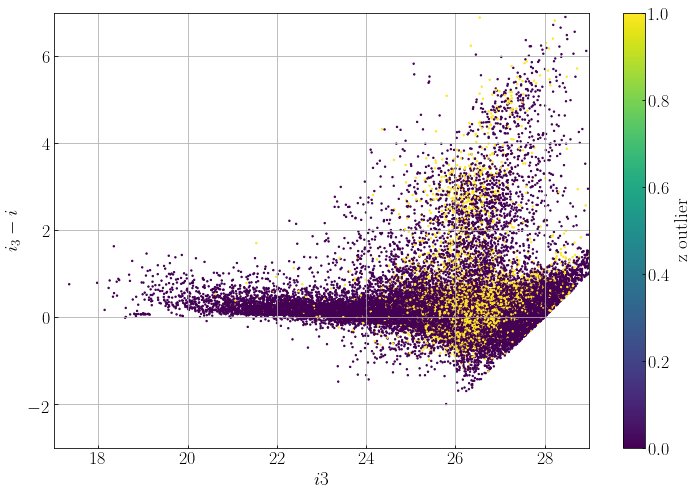

In [8]:
outlier_flag = 'z outlier'
z_outlier_flag = (abs(cat_matched['lp_zPDF_farmer']-cat_matched['ZPHOT_G'])>0.15*(1+cat_matched['lp_zPDF_farmer']))
if cat_mycosmos_type == 'after_sed':
    m_outlier_flag = (abs(cat_matched['lp_mass_med_farmer']-cat_matched['MASS_MED_massrun'])>0.3)
else:
    m_outlier_flag = np.ones(len(cat_matched))

if outlier_flag == 'z outlier':
    color_label = z_outlier_flag
else:
    color_label = m_outlier_flag
    

fig, axs = plt.subplots(1, 1, figsize = (12, 8))
im =plt.scatter(cat_matched['i_aper3'],cat_matched['i_aper3']-cat_matched['i'],s=2,c=z_outlier_flag)
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel(outlier_flag,fontsize=19)

plt.xlim([17,29])
plt.ylim([-3,7])
plt.xlabel('$i3$',fontsize=19)
plt.ylabel('$i_3 - i$',fontsize=19)
plt.grid()

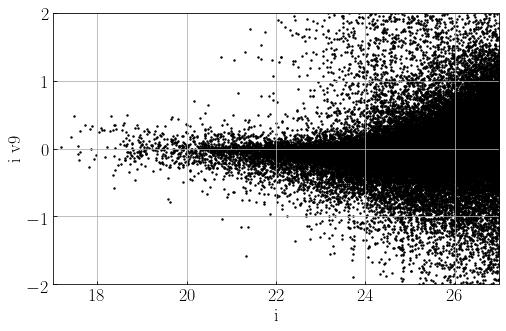

In [9]:
fig, axs = plt.subplots(1, 1, figsize = (8, 5))
plt.scatter(cat_matched['i'],cat_matched['i_v9']-cat_matched['i'],s=2,color='k')
plt.xlim([17,27])
plt.ylim([-2,2])
plt.xlabel('i',fontsize=18)
plt.ylabel('i v9',fontsize=18)
plt.grid()

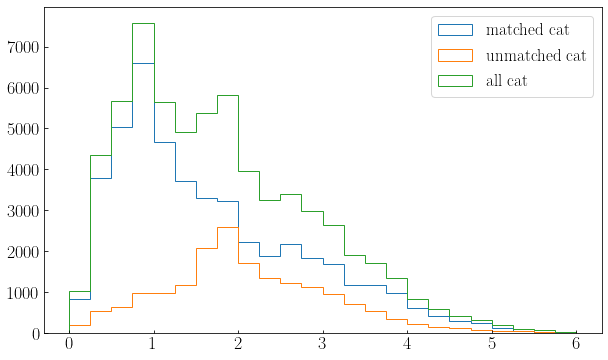

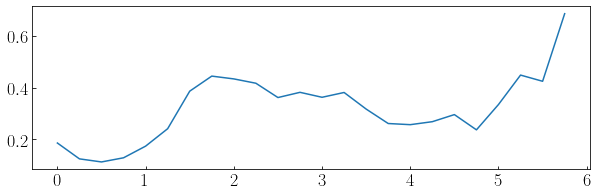

In [12]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6))
bin_size = 0.25
plt.hist(cat_matched[cat_matched['lp_zPDF_farmer']>0]['ZPHOT_G'],bins=np.arange(0,6+bin_size,bin_size),histtype='step',label='matched cat')
n_unmatched,bins,patches = plt.hist(cat_matched[np.isnan(cat_matched['lp_zPDF_farmer'])]['ZPHOT_G'],bins=np.arange(0,6+bin_size,bin_size),histtype='step',label='unmatched cat')
n_all,bins,patches = plt.hist(cat_matched['ZPHOT_G'],bins=np.arange(0,6+bin_size,bin_size), histtype='step',label='all cat')  
plt.legend(fontsize=17,loc='upper right')
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (10, 3))
plt.plot(bins[:-1], n_unmatched/n_all)

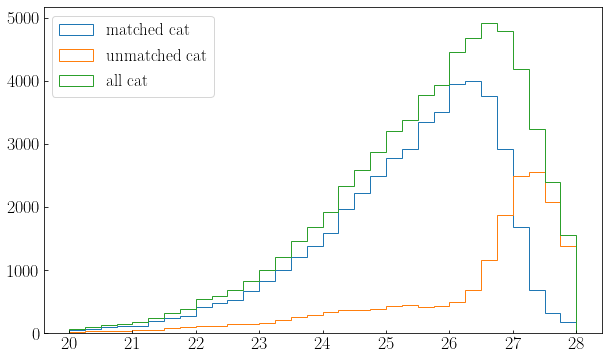

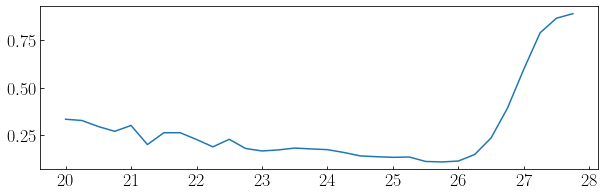

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6))
bin_size = 0.25
plt.hist(cat_matched[cat_matched['lp_zPDF_farmer']>0]['i'],bins=np.arange(20,28+bin_size,bin_size),histtype='step',label='matched cat')
n_unmatched,bins,patches = plt.hist(cat_matched[np.isnan(cat_matched['lp_zPDF_farmer'])]['i'],bins=np.arange(20,28+bin_size,bin_size),histtype='step',label='unmatched cat')
n_all,bins,patches = plt.hist(cat_matched['i'],bins=np.arange(20,28+bin_size,bin_size), histtype='step',label='all cat')  

plt.legend(fontsize=17,loc='upper left')
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (10, 3))
plt.plot(bins[:-1], n_unmatched/n_all)

it seems that unmatched galaxies are distributed more towards high-z and fainter, but not insignificant at z<1.5.



64199 17964
0


(-4, 6.5)

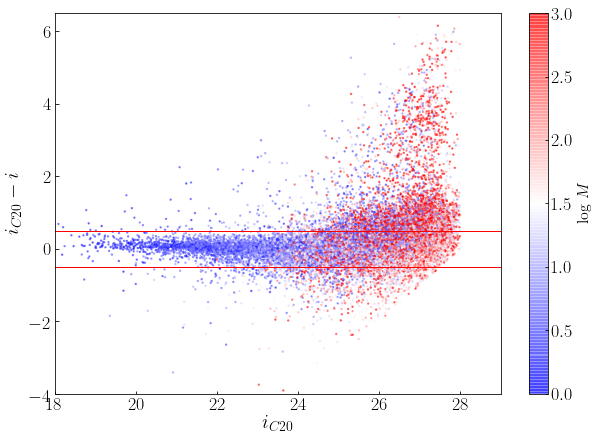

In [31]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7))

i_mag_c20 = cat_matched['HSC_i_MAG_farmer'].copy()
i_mag_pcat = cat_matched['i'].copy()
i_mag_offset = i_mag_c20-i_mag_pcat
mag_cut = 28

print(len(i_mag_c20),len(i_mag_c20[np.isnan(i_mag_c20)&(i_mag_pcat<mag_cut)]))
print(len(i_mag_c20[(i_mag_c20>mag_cut)&(i_mag_offset>0.5)&(i_mag_pcat<mag_cut)]))
      
im = plt.scatter(i_mag_c20,i_mag_offset ,s=2,c=cat_matched['ZPHOT_G'],vmin=0,vmax=3,alpha=0.5,cmap='bwr')
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('log $M$',fontsize=16)

# im = plt.scatter(i_mag_c20,i_mag_offset ,s=2,c=cat_matched['Z_COMBINE'],vmin=0,vmax=3,alpha=0.5,cmap='bwr')
# cbar = fig.colorbar(im, ax=axs)
# cbar.ax.set_ylabel('$z$',fontsize=16)

plt.hlines(xmin=16,xmax=30,y=0.5,color='r',linewidth=1)
plt.hlines(xmin=16,xmax=30,y=-0.5,color='r',linewidth=1)
plt.xlabel('$i_{C20}$',fontsize=20)
plt.ylabel('$i_{C20}-i$',fontsize=20)
plt.xlim([18,29])
plt.ylim([-4,6.5])

#### --------------



/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.019004 0.018063 1.0521


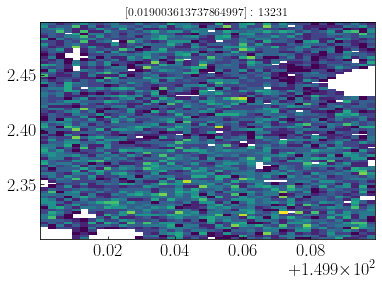

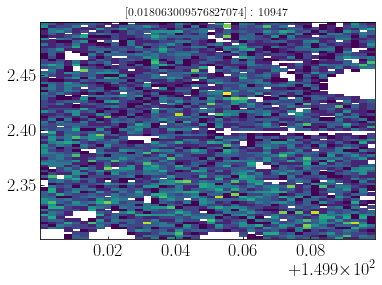

In [34]:
def ComnputeSurfaceXY(x, y, Plot=False, step=0.015):
    # need to change the step and cmin to converge towards the the most accurate surface
    xs, ys = [x], [y]
    size_tot = []
    for x, y in zip(xs, ys):
        # plt.figure()
        a, b, c = np.histogram2d(x, y, bins=[np.arange(x.min(), x.max(), step), np.arange(y.min(), y.max(), step)])
        size = (x.max() - x.min()) * (y.max() - y.min()) * np.cos(np.nanmedian(y) * np.pi / 180)
        size *= len(a[a > 0]) / a.size
        size_tot.append(size)
        if Plot:
            plt.figure()
            a, b, c, d = plt.hist2d(x, y, bins=[np.arange(x.min(), x.max(), step), np.arange(y.min(), y.max(), step)], cmin=1e-5)
            plt.title("%s : %s" % (size_tot, len(x)))
            #plt.show()
    return np.sum(size_tot)

step = 8.5/ 3600.
my_area = ComnputeSurfaceXY(cat_test_mycosmos['RA'], cat_test_mycosmos['DEC'], Plot=True, step=step)
C20_area = ComnputeSurfaceXY(cat_test_c20_farmer['ALPHA_J2000'], cat_test_c20_farmer['DELTA_J2000'], Plot=True, step=step)

print(round(my_area,6),round(C20_area,6),round(my_area/C20_area,4))

15.0 0 0 NaN
16.0 0 0 NaN
17.0 0 0 NaN
18.0 4 1
19.0 26 16
20.0 58 40
21.0 121 90
22.0 395 265
23.0 705 534
24.0 1511 1145
25.0 2468 1948
26.0 1596 1349
27.0 0 0 NaN
28.0 0 0 NaN
29.0 0 0 NaN
30.0 0 0 NaN


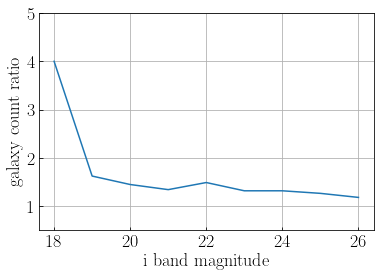

In [91]:
ratios = []
for i in np.linspace(15,30,16):
    cat_test_mycosmos_mag = cat_test_mycosmos[(cat_test_mycosmos['i']>i-0.5) & ((cat_test_mycosmos['i']<i+0.5))]
    cat_test_c20_mag = cat_test_c20_farmer[(cat_test_c20_farmer['HSC_i_MAG']>i-0.5) & ((cat_test_c20_farmer['HSC_i_MAG']<i+0.5))]
    if len(cat_test_c20_mag) != 0:
        print(i,len(cat_test_mycosmos_mag),len(cat_test_c20_mag))
        ratios.append(round(len(cat_test_mycosmos_mag)/len(cat_test_c20_mag),3))
    else:
        print(i,len(cat_test_mycosmos_mag),len(cat_test_c20_mag),'NaN')
        ratios.append(np.nan)
    
plt.plot(np.linspace(15,30,16),ratios)
plt.ylim([0.5,5])
plt.xlabel('i band magnitude',fontsize=18)
plt.ylabel('galaxy count ratio',fontsize=18)
plt.grid()

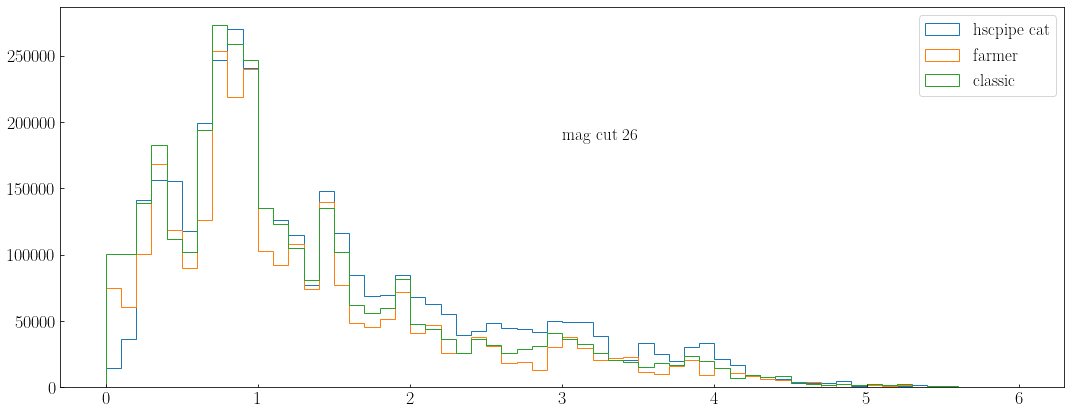

In [27]:
fig, axs = plt.subplots(1, 1, figsize = (18, 7))
bin_size=0.1
area_mycosmos = area_my_cosmos
area_c20 = area_c20_cosmos
plt.annotate('mag cut '+str(mag_cut), xy=(0.5, 0.65), xycoords='axes fraction', ha='left',fontsize=17)

plt.hist(cat_test_mycosmos['ZPHOT_G'],bins=np.arange(0,6+bin_size,bin_size), weights=np.ones(len(cat_test_mycosmos))/area_mycosmos/bin_size, histtype='step',label='hscpipe cat')
plt.hist(cat_test_c20_farmer['lp_zPDF'],bins=np.arange(0,6+bin_size,bin_size), weights=np.ones(len(cat_test_c20_farmer))/area_c20/bin_size, histtype='step',label='farmer')  
plt.hist(cat_test_c20_classic['lp_zPDF'],bins=np.arange(0,6+bin_size,bin_size), weights=np.ones(len(cat_test_c20_classic))/area_c20/bin_size, histtype='step',label='classic')
plt.legend(fontsize=17,loc='upper right')
plt.show()

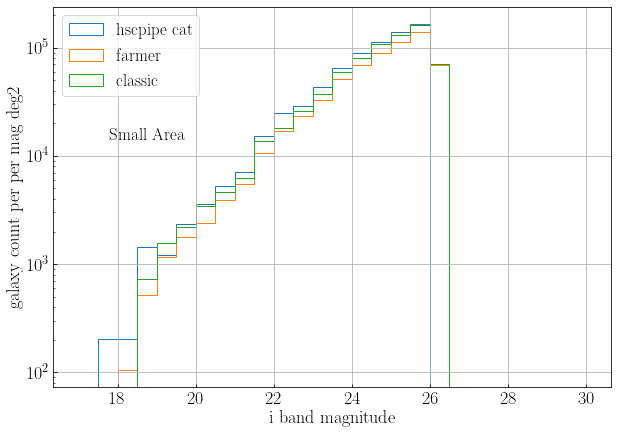

In [28]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7))
bin_size=0.5

area_mycosmos = area_my_cosmos
area_c20 = area_c20_cosmos
toal_mag_classic = cat_test_c20_classic['HSC_i_MAG_APER2']+cat_test_c20_classic['total_off2']

plt.hist(cat_test_mycosmos['i'],range=(17,30),bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_mycosmos))/area_mycosmos/bin_size, histtype='step',label='hscpipe cat')
plt.hist(cat_test_c20_farmer['HSC_i_MAG'],bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_c20_farmer))/area_c20/bin_size, histtype='step',label='farmer')  
plt.hist(toal_mag_classic,bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_c20_classic))/area_c20/bin_size, histtype='step',label='classic')

plt.annotate('Small Area', xy=(0.1, 0.65), xycoords='axes fraction', ha='left',fontsize=17)
plt.xlabel('i band magnitude',fontsize=18)
plt.yscale('log')
plt.ylabel('galaxy count per per mag deg2',fontsize=18)
plt.legend(fontsize=17,loc='upper left')
plt.grid()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7))
bin_size=0.5

area_mycosmos = area_my_cosmos
area_c20 = area_c20_cosmos
toal_mag_classic = cat_test_c20_classic['HSC_i_MAG_APER2']+cat_test_c20_classic['total_off2']

plt.hist(cat_test_mycosmos['i'],range=(17,30),bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_mycosmos))/area_mycosmos/bin_size, histtype='step',label='hscpipe cat')
plt.hist(cat_test_c20_farmer['HSC_i_MAG'],bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_c20_farmer))/area_c20/bin_size, histtype='step',label='farmer')  
plt.hist(toal_mag_classic,bins=np.arange(17,30+bin_size,bin_size), weights=np.ones(len(cat_test_c20_classic))/area_c20/bin_size, histtype='step',label='classic')

plt.annotate('Small Area', xy=(0.1, 0.65), xycoords='axes fraction', ha='left',fontsize=17)
plt.xlabel('i band magnitude',fontsize=18)
plt.yscale('log')
plt.ylabel('galaxy count per per mag deg2',fontsize=18)
plt.legend(fontsize=17,loc='upper left')
plt.grid()

700687 710242
15.0 0 0 NaN
16.0 0 0 NaN
17.0 0 0 NaN
18.0 158 116
19.0 1004 742
20.0 2819 2173
21.0 7222 5982
22.0 16731 14475
23.0 36790 31976
24.0 79595 67617
25.0 144054 120158
26.0 211635 196320
27.0 189453 228276
28.0 19073 29738
29.0 1447 2603
30.0 261 511
700687 710242
15.0 0 0 NaN
16.0 0 0 NaN
17.0 0 0 NaN
18.0 190 116
19.0 1023 742
20.0 2880 2173
21.0 7400 5982
22.0 16992 14475
23.0 37181 31976
24.0 79920 67617
25.0 143859 120158
26.0 210529 196320
27.0 188419 228276
28.0 19399 29738
29.0 1455 2603
30.0 288 511


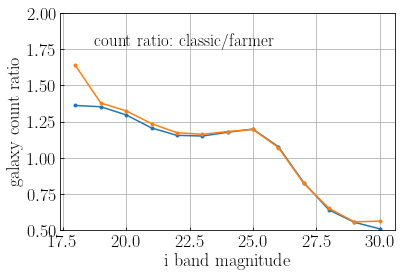

In [64]:
ratios = []
print(len(cat_C20_farmer),len(cat_C20_classic))
toal_mag_classic = cat_C20_classic['HSC_i_MAG_APER2']+cat_C20_classic['total_off2']
for i in np.linspace(15,30,16):
    cat_test_c20_farmer_mag = cat_C20_farmer[(cat_C20_farmer['HSC_i_MAG']>i-0.5) & ((cat_C20_farmer['HSC_i_MAG']<i+0.5))]
    toal_mag_classic_mag = toal_mag_classic[(toal_mag_classic>i-0.5) & ((toal_mag_classic<i+0.5))]
    if len(cat_test_c20_farmer_mag) != 0:
        print(i,len(toal_mag_classic_mag),len(cat_test_c20_farmer_mag))
        ratios.append(round(len(toal_mag_classic_mag)/len(cat_test_c20_farmer_mag),3))
    else:
        print(i,len(toal_mag_classic_mag),len(cat_test_c20_farmer_mag),'NaN')
        ratios.append(np.nan)
    
plt.plot(np.linspace(15,30,16),ratios,'.-')


ratios = []
print(len(cat_C20_farmer),len(cat_C20_classic))
for i in np.linspace(15,30,16):
    cat_test_c20_farmer_mag = cat_C20_farmer[(cat_C20_farmer['HSC_i_MAG']>i-0.5) & ((cat_C20_farmer['HSC_i_MAG']<i+0.5))]
    cat_test_c20_classic_mag = cat_C20_classic[(cat_C20_classic['HSC_i_MAG_AUTO']>i-0.5) & ((cat_C20_classic['HSC_i_MAG_AUTO']<i+0.5))]
    if len(cat_test_c20_farmer_mag) != 0:
        print(i,len(cat_test_c20_classic_mag),len(cat_test_c20_farmer_mag))
        ratios.append(round(len(cat_test_c20_classic_mag)/len(cat_test_c20_farmer_mag),3))
    else:
        print(i,len(cat_test_c20_classic_mag),len(cat_test_c20_farmer_mag),'NaN')
        ratios.append(np.nan)
    
plt.plot(np.linspace(15,30,16),ratios,'.-')
plt.annotate('count ratio: classic/farmer', xy=(0.1, 0.85), xycoords='axes fraction', ha='left',fontsize=17)
plt.ylim([0.5,2])
plt.xlabel('i band magnitude',fontsize=18)
plt.ylabel('galaxy count ratio',fontsize=18)
plt.grid()
plt.show()

15.0 0 0 NaN
16.0 0 0 NaN
17.0 0 0 NaN
18.0 35 16
19.0 222 164
20.0 522 369
21.0 1397 1116
22.0 3218 2699
23.0 6812 5810
24.0 14415 12052
25.0 25382 21268
26.0 17165 15468


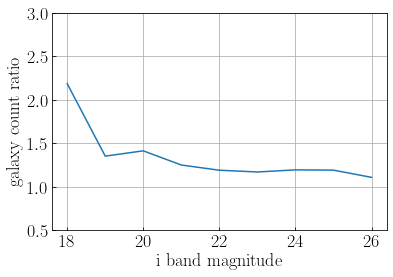

In [77]:
ratios = []
for i in np.linspace(15,26,12):
    cat_test_c20_farmer_mag = cat_test_c20_farmer[(cat_test_c20_farmer['HSC_i_MAG']>i-0.5) & ((cat_test_c20_farmer['HSC_i_MAG']<i+0.5))]
    cat_test_c20_classic_mag = cat_test_c20_classic[(cat_test_c20_classic['HSC_i_MAG_AUTO']>i-0.5) & ((cat_test_c20_classic['HSC_i_MAG_AUTO']<i+0.5))]
    if len(cat_test_c20_farmer_mag) != 0:
        print(i,len(cat_test_c20_classic_mag),len(cat_test_c20_farmer_mag))
        ratios.append(round(len(cat_test_c20_classic_mag)/len(cat_test_c20_farmer_mag),3))
    else:
        print(i,len(cat_test_c20_classic_mag),len(cat_test_c20_farmer_mag),'NaN')
        ratios.append(np.nan)
    
plt.plot(np.linspace(15,26,12),ratios)
plt.ylim([0.5,3])
plt.xlabel('i band magnitude',fontsize=18)
plt.ylabel('galaxy count ratio',fontsize=18)
plt.grid()

In [41]:
combined_cat_name = cat_mycosmos_name.replace('.fits','_match_c20all.fits')
print(combined_cat_name)

ref_cat = 'mycat' # 1=my catalog, 2=C20 catalog
join = 'all1'

# ref_cat = 'C20' # 1=my catalog, 2=C20 catalog
# join = 'all2'

cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="0.5"\
   in1='+cat_mycosmos_name + ' values1="RA DEC" \
   in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits values2="ALPHA_J2000 DELTA_J2000"  join='+join+'\
   out='+ combined_cat_name

# cmd = 'java -jar stilts.jar tmatch2 matcher=sky+1d params="0.5 1"\
#    in1='+cat_mycosmos_name + ' values1="RA DEC i" \
#    in2='+cat_c20_name +' values2="ALPHA_J2000 DELTA_J2000 HSC_i_MAG"  join='+join+'\
#    out='+ combined_cat_name

os.system(cmd)

cat_matched_allc20 = Table.read(combined_cat_name)
for keyname in cat_matched_allc20.keys():
    if '_1' in keyname:
        cat_matched_allc20.remove_column(keyname)
    elif '_2' in keyname:
        cat_matched_allc20.rename_column(keyname,keyname.replace('_2',''))
        
cat_matched_allc20 = cat_matched_allc20['ALPHA_J2000','DELTA_J2000','RA','DEC','lp_zPDF','lp_mass_med','Z_COMBINE','MASS_MED_massrun','i','HSC_i_MAG','sfq_nuvrk_myrun_free','CLASS']
cat_matched_allc20.write(cat_mycosmos_name.replace('.fits','_match_c20all.fits'), overwrite=True)

/Volumes/LejaySSD/pcat_lephare_masses/COSMOS_galaxies_240408_match_c20all.fits


78006 67043
sf/q ratio for matched gals 19.309
sf/q ratio for unmatched gals 18.422


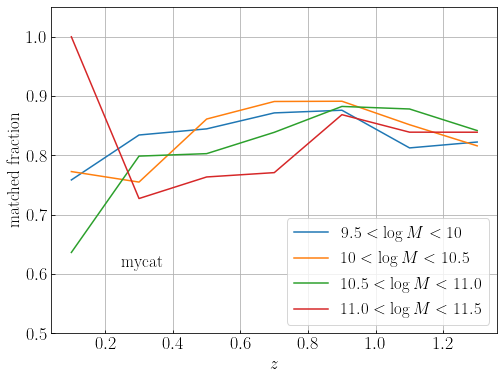

In [42]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6))

if ref_cat == 'C20':
    ra_name = 'ALPHA_J2000'
    dec_name = 'DELTA_J2000'
    z_keyname = 'lp_zPDF'
    m_keyname = 'lp_mass_med'
    sfq_name = 'CLASS'  # 1=sf, 0=q
    matched_z_keyname = 'Z_COMBINE'
else:
    ra_name = 'RA'
    dec_name = 'DEC'
    z_keyname = 'Z_COMBINE'
    m_keyname = 'MASS_MED_massrun'
    sfq_name = 'sfq_nuvrk_myrun_free' #1=sq, 0=q
    matched_z_keyname = 'lp_zPDF'
    
cat_test_c20 = cat_matched_allc20[cat_matched_allc20[ra_name] > 149.9]
cat_test_c20 = cat_test_c20[cat_test_c20[ra_name] < 150.3]
cat_test_c20 = cat_test_c20[cat_test_c20[dec_name] > 1.9]
cat_test_c20 = cat_test_c20[cat_test_c20[dec_name] < 2.6]
print(len(cat_test_c20),len(cat_test_c20[cat_test_c20[matched_z_keyname]>0]))

# q-fraction of matched/unmatched galaxies
cat_test_matched = cat_test_c20[~np.isnan(cat_test_c20[matched_z_keyname])]
cat_test_unmatched = cat_test_c20[np.isnan(cat_test_c20[matched_z_keyname])]
print('sf/q ratio for matched gals',round(len(cat_test_matched[cat_test_matched[sfq_name]==1])/len(cat_test_matched[cat_test_matched[sfq_name]==0]),3))
print('sf/q ratio for unmatched gals',round(len(cat_test_unmatched[cat_test_unmatched[sfq_name]==1])/len(cat_test_unmatched[cat_test_unmatched[sfq_name]==0]),3))

m_list = [9.5,10,10.5,11.0,11.5]
for m_idx in range(len(m_list)-1):
    m_min = m_list[m_idx]
    m_max = m_list[m_idx+1]
    cat_m = cat_test_c20[(cat_test_c20[m_keyname]>m_min) &(cat_test_c20[m_keyname]<m_max)]
    matched_frac = []
    for z in np.arange(0,1.4,0.2):
        cat_zm = cat_m[(cat_m[z_keyname]>z) & (cat_m[z_keyname]<z+0.2)]
        matched_cat_zm = cat_zm[cat_zm[matched_z_keyname]>0]
        try:
            matched_frac.append(len(matched_cat_zm)/len(cat_zm))
        except ZeroDivisionError:
            matched_frac.append(0)
    plt.plot(np.arange(0,1.4,0.2)+0.1,matched_frac,label='$'+str(m_min)+'<\log M <'+str(m_max)+'$')
    
plt.legend(fontsize=17)
plt.annotate(ref_cat, xy=(0.25, 0.2), xycoords='axes fraction', ha='right',fontsize=17)
plt.xlabel('$z$',fontsize=17)
plt.ylabel('matched fraction',fontsize=17)
plt.ylim([0.5,1.05])
plt.grid()

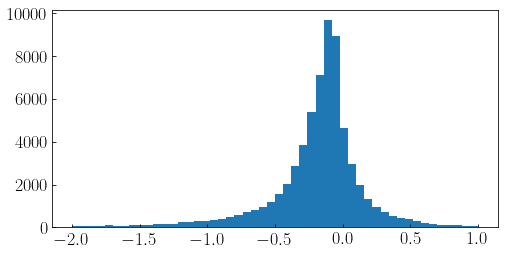

In [55]:
# magnitude difference distribution
fig, axs = plt.subplots(1, 1, figsize = (8, 4))
plt.hist(cat_test_c20['i']-cat_test_c20['HSC_i_MAG'],range=(-2,1),bins=50)
plt.show()

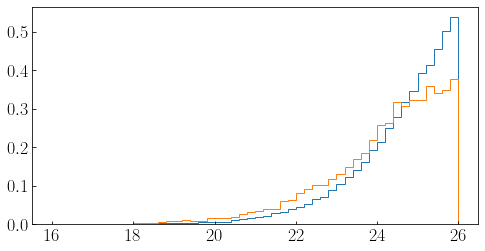

In [56]:
# magnitude difference distribution
fig, axs = plt.subplots(1, 1, figsize = (8, 4))
plt.hist(cat_test_c20[~np.isnan(cat_test_c20['lp_zPDF'])]['i'],range=(16,26),bins=50,density=True,histtype='step')
plt.hist(cat_test_c20[np.isnan(cat_test_c20['lp_zPDF'])]['i'],range=(16,26),bins=50,density=True,histtype='step')
plt.show()

Text(0, 0.5, 'log M')

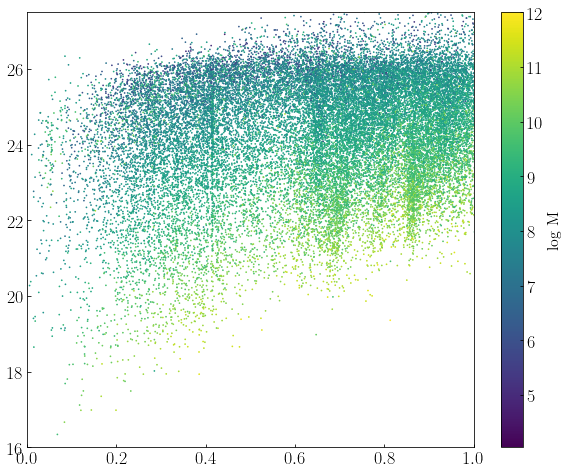

In [59]:
# magnitude difference distribution
fig, axs = plt.subplots(1, 1, figsize = (10, 8))
# plt.scatter(cat_test_unmatched['Z_COMBINE'],cat_test_unmatched['HSC_i_MAG'],s=0.5)
im = axs.scatter(cat_test_matched['Z_COMBINE'],cat_test_matched['HSC_i_MAG'],s=0.5,c=cat_test_matched['lp_mass_med'])
axs.set_xlim([0,1])
axs.set_ylim([16,27.5])

cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('log M',fontsize=16)

##### z/mass calibartion

3206
1411
214


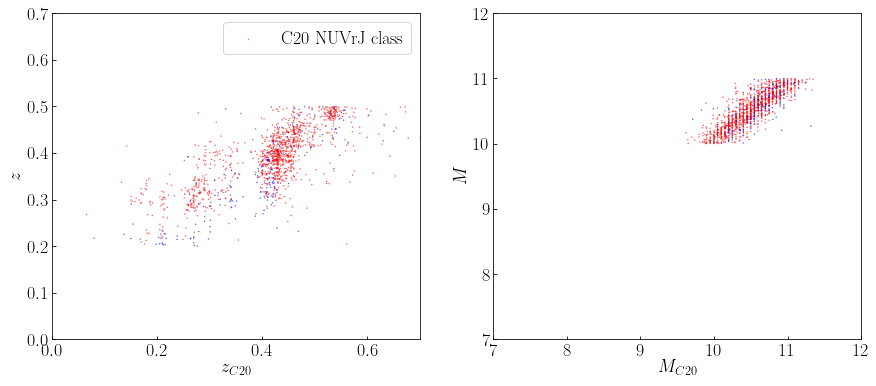

In [65]:
fig, axs = plt.subplots(1, 2, figsize = (14.5, 6))

cat_matched_test = cat_matched[(cat_matched['Z_COMBINE']>0.2) &(cat_matched['Z_COMBINE']<0.5)]
cat_matched_test = cat_matched_test[(cat_matched_test['MASS_MED_massrun']>10) & (cat_matched_test['MASS_MED_massrun']<11)]

print(len(cat_matched_test))
rk = np.array(cat_matched_test['MAG_ABS_r'] - cat_matched_test['MAG_ABS_Ks'])
delta_gv = cat_matched_test['MAG_ABS_NUV'] - cat_matched_test['MAG_ABS_r']-boundary_4d(rk, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_matched_test['Z_COMBINE'], cat_matched_test['MASS_MED_massrun'])
cat_matched_test = cat_matched_test[delta_gv>0]
print(len(cat_matched_test))

cat_matched_test = cat_matched_test[(cat_matched_test['Z_COMBINE']>0.2) &(cat_matched_test['Z_COMBINE']<0.5)]
cat_matched_test = cat_matched_test[(cat_matched_test['MASS_MED_massrun']>10) & (cat_matched_test['MASS_MED_massrun']<11)]

# z
axs[0].scatter(cat_matched_test['lp_zPDF'],cat_matched_test['Z_COMBINE'],s=0.1,c=cat_matched_test['CLASS'],alpha=1,cmap='bwr_r',label='C20 NUVrJ class')
axs[0].set_xlabel('$z_{C20}$',fontsize=18)
axs[0].set_ylabel('$z$',fontsize=18)
axs[0].set_xlim([0.0,0.7])
axs[0].set_ylim([0.0,0.7])
axs[0].legend(fontsize=18)

# M
axs[1].scatter(cat_matched_test['lp_mass_med'],cat_matched_test['MASS_MED_massrun'],s=0.1,c=cat_matched_test['CLASS'],alpha=1,cmap='bwr_r')
axs[1].set_xlabel('$M_{C20}$',fontsize=18)
axs[1].set_ylabel('$M$',fontsize=18)
axs[1].set_xlim([7,12])
axs[1].set_ylim([7,12])

print(len(cat_matched_test[cat_matched_test['CLASS']==1]))

#### Define SF/Q boundary
in NUVrK diagrams

Text(0.05, 0.93, 'M-facor=0.02')

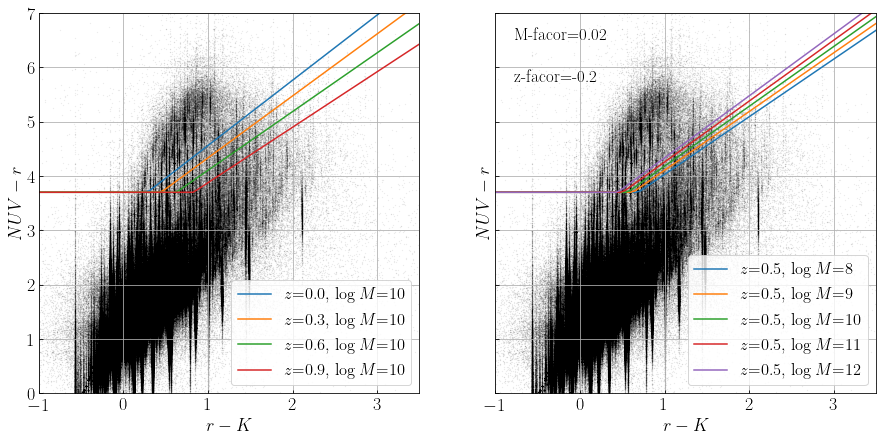

In [27]:
# example show boundary 4d

fig, axs = plt.subplots(1, 2, figsize = (15, 7), sharey=True)
rk_draw = np.linspace(-1,3.5,80)

cat_central_cosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits'
cat = Table.read(cat_central_cosmos_name)
cat = cat[cat['inside_u'] == True]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isStar']==False]
cat = cat[cat['isCompact']==False]
cat = cat[cat['i_compact_flag']==False]
cat = cat[cat['snr_i']>3]
cat = cat[cat['snr_r']>1.5]
cat = cat[cat['snr_z']>1.5]
cat = cat[cat['i_cmodel']>0]

axs[0].scatter(cat['MAG_ABS_r']-cat['MAG_ABS_Ks'],cat['MAG_ABS_NUV']-cat['MAG_ABS_r'],alpha=0.1,s=0.1,color='k')
axs[1].scatter(cat['MAG_ABS_r']-cat['MAG_ABS_Ks'],cat['MAG_ABS_NUV']-cat['MAG_ABS_r'],alpha=0.1,s=0.1,color='k')

M = 10
for z in [0.0,0.3,0.6,0.9]:
    nuv_draw_mid = boundary_4d(rk_draw, 3.7 , 2.8,   1., -0.2,  0.02, z, M)
    axs[0].plot(rk_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M))

axs[0].set_xlabel('$r-K$',fontsize=18)
axs[0].set_ylabel('$NUV-r$',fontsize=18)
axs[0].set_xlim([-1,3.5])
axs[0].set_ylim([0,7])
axs[0].grid()
axs[0].legend(fontsize=16.5)

z = 0.5
for M in [8,9,10,11,12]:
    nuv_draw_mid = boundary_4d(rk_draw, 3.7 , 2.8,   1., -0.2,  0.02, z, M)
    axs[1].plot(rk_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M))
axs[1].set_xlabel('$r-K$',fontsize=18)
axs[1].set_ylabel('$NUV-r$',fontsize=18)
axs[1].set_xlim([-1,3.5])
axs[1].set_ylim([0,7])
axs[1].grid()
axs[1].legend(fontsize=16.5)
axs[1].annotate('z-facor=-0.2', xy=(0.05, 0.82), xycoords='axes fraction', ha='left',fontsize=17)
axs[1].annotate('M-facor=0.02', xy=(0.05, 0.93), xycoords='axes fraction', ha='left',fontsize=17)


#### The Cost Function / other functions

In [72]:
# boundary_type = 2d: (NUV-r,r-K) 2d space
# boundary_type = 4d: (NUV-r,r-K,z,M) 4d space

def cost_function(params, data, q_labels, boundary_type, cost_type, r_factor=3 ,eval_type='q'):
    color1 = data[:,0]
    color2 = data[:,1]
    zVal = data[:,2]
    MVal = data[:,3]
    
    if boundary_type == '2d':
        ic_1,ic_2,slope = params
        delta_boundary = color2 - np.maximum(ic_1, slope*color1 + ic_2)
    elif boundary_type == '3d':
        ic_1,ic_2,slope,M_factor = params
        delta_boundary = color2 - np.maximum(ic_1, (slope+M_factor*MVal)*color1 + ic_2)
    else:
        ic_1,ic_2,slope,z_factor,M_factor = params
        delta_boundary = color2 - np.maximum(ic_1, (slope+z_factor*zVal+M_factor*MVal)*(color1 + ic_2))     
    
    q = delta_boundary > 0 # binary list, above boundary flags
    sf = delta_boundary <= 0 # binary list, below boundary flags
    true_q = q_labels==1 
    true_sf = q_labels==0
    
    if eval_type=='q':
        FP = np.sum(true_sf*q)  # false positive
        TP = np.sum(true_q*q)   # true positive
        FN = np.sum(true_q*sf)  # false negative
        TN = np.sum(true_sf*sf) # true negative
    elif eval_type=='sf':
        FP = np.sum(true_q*sf)  # false positive
        TP = np.sum(true_sf*sf)  # true positive
        FN = np.sum(true_sf*q)  # false negative
        TN = np.sum(true_q*q) # true negative
    else:
        raise ValueError('either sf or q')
    
    # calculate the cost function
    if TP+FP>0:
        fc = FP/(TP+FP)
    else:
        fc=0.99
    
    if TP+FN>0:
        fm = FN/(TP+FN)
    else:
        fm=0.99
            
    if cost_type == 'fcfm': # original formula from Holden et al. 2012
        if eval_type =='sf':
            score = fc + r_factor*fm + abs(fc-r_factor*fm)
        else:
            score = r_factor*fc + fm + abs(r_factor*fc-fm) 
            
    else: # Angelo's cost function
        score = -(1*TP + 1*TN - 4*FP - 3*FN -3*fm)
        
    return score


def cost_function_a(params, X, y):
    ic_1, ic_2, slope, z_factor, M_factor = params
    rK, Nr, Zval, Mval = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    y_pred = (Nr > ((slope + z_factor * Zval + M_factor * Mval) * (rK + ic_2))) & (Nr > ic_1)
        
    true_positives = np.sum((y_pred == 1) & (y == 1))
    true_negatives = np.sum((y_pred == 0) & (y == 0))
    false_positives = np.sum((y_pred == 1) & (y == 0))
    false_negatives = np.sum((y_pred == 0) & (y == 1))
    
    missing_frac = false_negatives/(true_positives+false_negatives)

    return -(1*true_positives + 1*true_negatives - 4*false_positives - 3*false_negatives -3*missing_frac)


def div_err(a,b):
    # for c=a/b
    c = a/b
    return c*np.sqrt((1/np.sqrt(a))**2+(1/np.sqrt(b))**2)

def fc_fm(q,sf,true_q,true_sf,eval_type='q'):
    if eval_type=='q':
        FP = np.sum(true_sf*q)  # false positive
        TP = np.sum(true_q*q)   # true positive
        FN = np.sum(true_q*sf)  # false negative
        TN = np.sum(true_sf*sf) # true negative
    else:
        FP = np.sum(true_q*sf)  # false positive
        TP = np.sum(true_sf*sf)   # true positive
        FN = np.sum(true_sf*q)  # false negative
        TN = np.sum(true_q*q) # true negative
        
    
    #print(FP,TP,FN,TN)
    # calculate the cost function
    if TP+FP>0:
        fc = FP/(TP+FP)
    else:
        fc=0.99
    
    if TP+FN>0:
        fm = FN/(TP+FN)
    else:
        fm=0.99
    
    return fc,fm

# fc/fm as function in z or M 
def plot_fcfm(data, q_labels, q, sf, label='',eval_type='q',plot=True, title = ''):
    
    #### as function of z ###
    fc = []
    fm = []
    fc_err = []
    fm_err = []
    z_binl = np.linspace(min(data[:,2]),max(data[:,2]),10)
    
    true_q_all = q_labels==1 
    true_sf_all = q_labels==0
    fc_all,fm_all = fc_fm(q,sf,true_q_all,true_sf_all,eval_type=eval_type)
    
    for x in range(len(z_binl)-1):
        lm, um = 9.5, max(data[:,3])
        lz, uz = z_binl[x], z_binl[x+1]               
        cond=(data[:,3]>=lm)&(data[:,3]<um)&(data[:,2]>=lz)&(data[:,2]<uz)
        q_Mbin = q[cond]
        sf_Mbin = sf[cond]
        
        true_q = q_labels[cond]==1 
        true_sf = q_labels[cond]==0
        if eval_type=='q':
            FP = np.sum(true_sf*q_Mbin)  # false positive
            TP = np.sum(true_q*q_Mbin)   # true positive
            FN = np.sum(true_q*sf_Mbin)  # false negative
            TN = np.sum(true_sf*sf_Mbin) # true negative
        else:
            FP = np.sum(true_q*sf_Mbin)  # false positive
            TP = np.sum(true_sf*sf_Mbin)   # true positive
            FN = np.sum(true_sf*q_Mbin)  # false negative
            TN = np.sum(true_q*q_Mbin) # true negative
        
        # the fracions
        fc.append(FP/(FP+TP))
        fc_err.append(div_err(FP,FP+TP))
        fm.append(FN/(TP+FN))
        fm_err.append(div_err(FN,TP+FN))
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize = (16, 5), sharey=True)  
        z_binl=np.array(z_binl)
        axs[0].errorbar((z_binl[:-1]+z_binl[1:])/2,fc,yerr=fc_err,fmt='.-',label='fc',color='tab:blue')
        axs[0].errorbar((z_binl[:-1]+z_binl[1:])/2,fm,yerr=fm_err,fmt='.-',label='fm',color='tab:green')
        axs[0].legend(fontsize=17)
        axs[0].set_xlabel('Redshift',fontsize=17)
        axs[0].set_ylabel('Fraction',fontsize=17)
        axs[0].set_title(title,fontsize=17)
        axs[0].annotate(label,xy=([0.2,0.85]),xycoords='axes fraction',fontsize=17,color='k')
        axs[0].set_ylim([0,0.5])
        axs[0].grid()
    
    #### as function of M ###
    fc = []
    fm = []
    fc_err = []
    fm_err = []
    m_binl = np.linspace(9.5, 12.2, 10)
    for x in range(len(m_binl)-1):
        lm, um = m_binl[x], m_binl[x+1]
        lz, uz = min(data[:,2]),max(data[:,2])
                         
        cond=(data[:,3]>=lm)&(data[:,3]<um)&(data[:,2]>=lz)&(data[:,2]<uz)
        q_Mbin = q[cond]
        sf_Mbin = sf[cond]
        true_q = q_labels[cond]==1 
        true_sf = q_labels[cond]==0
        
        if eval_type=='q':
            FP = np.sum(true_sf*q_Mbin)  # false positive
            TP = np.sum(true_q*q_Mbin)   # true positive
            FN = np.sum(true_q*sf_Mbin)  # false negative
            TN = np.sum(true_sf*sf_Mbin) # true negative
        else:
            FP = np.sum(true_q*sf_Mbin)  # false positive
            TP = np.sum(true_sf*sf_Mbin)   # true positive
            FN = np.sum(true_sf*q_Mbin)  # false negative
            TN = np.sum(true_q*q_Mbin) # true negative
            
        #print(round(lm,1),round(um,1),np.sum(q_Mbin),np.sum(sf_Mbin),FP,TP,FN,TN)
        
        # the fractions
        fc.append(FP/(FP+TP))
        fc_err.append(div_err(FP,FP+TP))
        fm.append(FN/(TP+FN))
        fm_err.append(div_err(FN,TP+FN))
        #print(round(FP/(FP+TP),2),round(FN/(TP+FN),2))
    
    if plot:
        m_binl=np.array(m_binl)
        axs[1].errorbar((m_binl[:-1]+m_binl[1:])/2, fc, yerr=fc_err,fmt='.-',color='tab:blue')
        axs[1].errorbar((m_binl[:-1]+m_binl[1:])/2, fm, yerr=fm_err,fmt='.-',color='tab:green')
        axs[1].set_xlabel('log Mass',fontsize=17)
        axs[1].set_ylabel('Fraction',fontsize=17)
        axs[1].set_title(title,fontsize=17)
        axs[1].annotate(label,xy=([0.2,0.85]),xycoords='axes fraction',fontsize=17,color='k')
        axs[1].grid()
    
    return fc_all,fm_all

# 2D plot: fc/fm as function in (z,M) 
def plot_zm_fcfm(data, q_labels, q, sf, eval_type='q'):
    fig, ax = plt.subplots(1, 1, figsize = (15, 9), sharey=True)  
    
    z_binl = np.linspace(0, 0.9, 8)  
    M_binl = np.linspace(9.5, 12.0, 8)  
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
    cmap = cm.summer
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for z_idx in range(len(z_binl[:-1])):
        for M_idx in range(len(M_binl[:-1])):
            lz,uz = z_binl[z_idx],z_binl[z_idx+1]
            lm,um = M_binl[M_idx],M_binl[M_idx+1]
            
            cond=(data[:,3]>=lm)&(data[:,3]<um)&(data[:,2]>=lz)&(data[:,2]<uz)
            q_bin = q[cond]
            sf_bin = sf[cond]
            true_q = q_labels[cond]==1 
            true_sf = q_labels[cond]==0
            
            fc,fm = fc_fm(q_bin,sf_bin,true_q,true_sf,eval_type=eval_type)
            fc = round(fc,3)
            rect = patches.Rectangle((lm,lz), um-lm, uz-lz, facecolor=m.to_rgba(fc))

            # Add the patch to the Axes
            ax.add_patch(rect)
            ax.set_xlim([9.5,12])
            ax.set_ylim([0.0,0.9])
            ax.set_xlabel('log $M$',fontsize=18)
            ax.set_ylabel('$z$',fontsize=18)
            ax.annotate(str(fc), xy=(lm+(um-lm)/3,lz+(uz-lz)/1.7), xycoords='data',fontsize=16)
            ax.annotate('('+str(np.sum(q_bin))+','+str(np.sum(sf_bin))+')', xy=(lm+(um-lm)/4,lz+(uz-lz)/2.5), xycoords='data',fontsize=14)
        
    im = ax.scatter(np.zeros(len(q_bin)),np.zeros(len(q_bin)), s=0.03, alpha=1.0, c=np.zeros(len(q_bin)),vmin=0.0,vmax=1,cmap='summer')
    fig.colorbar(im,ax=ax)

#### test on internal COSMOS2020 difference

In [59]:
cat_combine_c20 = Table.read('/Users/lejay/COSMOS2020/COSMOS2020_COMBINE_R1_v2.2_trim.fits')

In [60]:
cat_combine_c20_z = cat_combine_c20[(cat_combine_c20['lp_zPDF_farmer']>0) & (cat_combine_c20['lp_zPDF_farmer']<1.5)]
cat_combine_c20_z = cat_combine_c20_z[cat_combine_c20_z['HSC_i_MAG_AUTO']<25]
cat_combine_c20_z = cat_combine_c20_z[cat_combine_c20_z['HSC_i_MAG_AUTO']>0]
cat_combine_c20_z = cat_combine_c20_z[cat_combine_c20_z['lp_mass_med_farmer']>9.0]
cat_combine_c20_z = cat_combine_c20_z[cat_combine_c20_z['lp_mass_med_farmer']<12.5]
cat_combine_c20_z = cat_combine_c20_z[cat_combine_c20_z['flag_photoz']>0]

print(len(cat_combine_c20_z))

103413


In [61]:
# data and reference labels
Mval = cat_combine_c20_z['lp_mass_med_farmer']
Zval = cat_combine_c20_z['lp_zPDF_farmer']
NR, RK = (cat_combine_c20_z['lp_MNUV_farmer']-cat_combine_c20_z['lp_MR_farmer']), (cat_combine_c20_z['lp_MR_farmer']-cat_combine_c20_z['lp_MK_farmer'])
data = np.array([RK, NR, Zval, Mval]).T

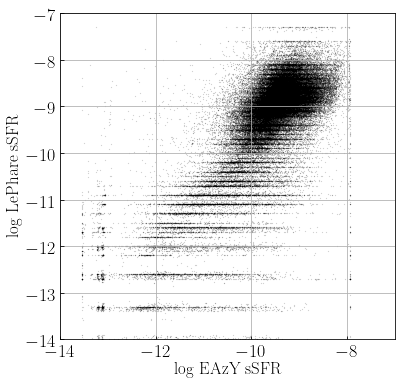

In [62]:
fig, axs = plt.subplots(1, 1, figsize = (6, 6), sharey=True)
plt.scatter(cat_combine_c20_z['ez_ssfr_p500_farmer'],cat_combine_c20_z['lp_sSFR_med_farmer'],s=0.03,alpha=0.4,color='k')
plt.xlabel('log EAzY sSFR',fontsize=17)
plt.ylabel('log LePhare sSFR',fontsize=17)
plt.xlim([-14,-7])
plt.ylim([-14,-7])
plt.grid()

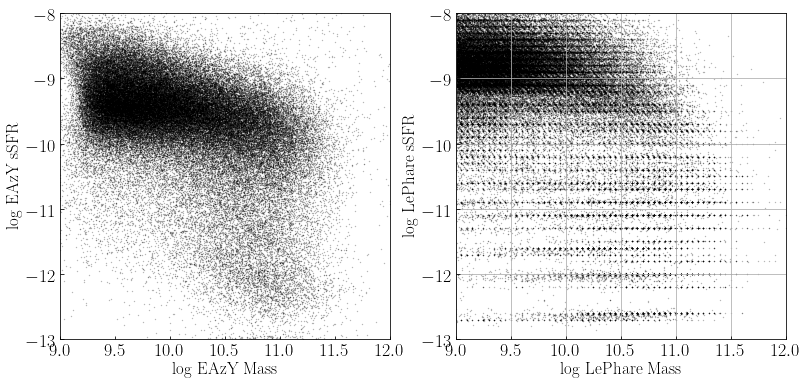

In [63]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
axs[0].scatter(cat_combine_c20_z['ez_mass_p500_farmer'],cat_combine_c20_z['ez_ssfr_p500_farmer'],s=0.1,alpha=0.4,color='k')
axs[0].set_xlabel('log EAzY Mass',fontsize=17)
axs[0].set_ylabel('log EAzY sSFR',fontsize=17)
axs[0].set_xlim([9,12])
axs[0].set_ylim([-13,-8])

axs[1].scatter(cat_combine_c20_z['lp_mass_med_farmer'],cat_combine_c20_z['lp_sSFR_med_farmer'],s=0.1,alpha=0.4,color='k')
axs[1].set_xlabel('log LePhare Mass',fontsize=17)
axs[1].set_ylabel('log LePhare sSFR',fontsize=17)
axs[1].set_xlim([9,12])
axs[1].set_ylim([-13,-8])

plt.grid()

##### plots: internal COSMOS2020 difference

fc=0.057 fm=0.172


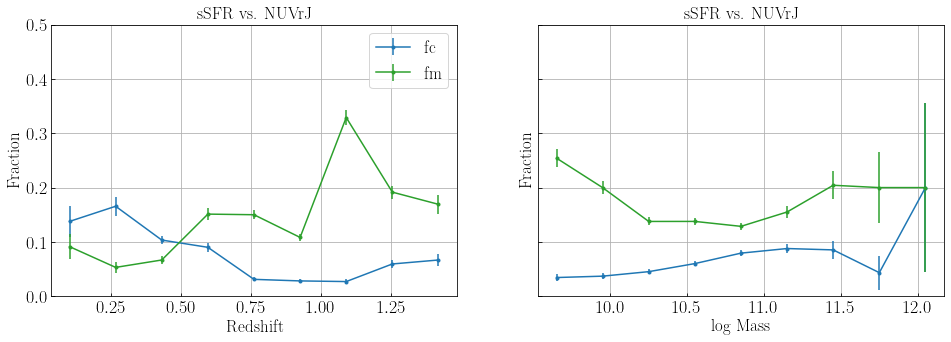

In [74]:
# ssfr vs nuvrj (farmer)

q_labels = (cat_combine_c20_z['CLASS_farmer']==0).astype(int)
true_q = q_labels==1
true_sf = q_labels==0  

q = (cat_combine_c20_z['lp_sSFR_med_farmer']<-11).astype(int)
sf = (cat_combine_c20_z['lp_sSFR_med_farmer']>-11).astype(int)

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
plot_fcfm(data, q_labels, q, sf, title='sSFR vs. NUVrJ')
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

fc=0.119 fm=0.057


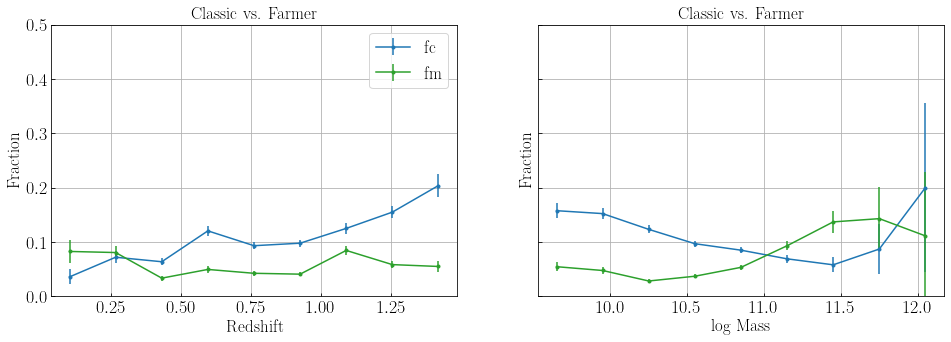

In [75]:
# classic vs farmer (lephare, nuvrj/ssfr)
c20_ref_type = 'ssfr'
if c20_ref_type == 'ssfr':
    q_labels = np.array([0 for x in range(len(cat_combine_c20_z))])
    q_labels[cat_combine_c20_z['lp_sSFR_med_classic']<-11]=1
    q = (cat_combine_c20_z['lp_sSFR_med_farmer']<-11).astype(int)
    sf = (cat_combine_c20_z['lp_sSFR_med_farmer']>=-11).astype(int)
elif c20_ref_type == 'nuvrj':    
    q_labels = (cat_combine_c20_z['CLASS_classic']==0).astype(int)
    q = (cat_combine_c20_z['CLASS_farmer']==0).astype(int)
    sf = (cat_combine_c20_z['CLASS_farmer']==1).astype(int)
    
true_q = q_labels==1
true_sf = q_labels==0

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
plot_fcfm(data, q_labels, q, sf,title='Classic vs. Farmer')
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

fc=0.211 fm=0.108


(0.21137887009256304, 0.10843482183130357)

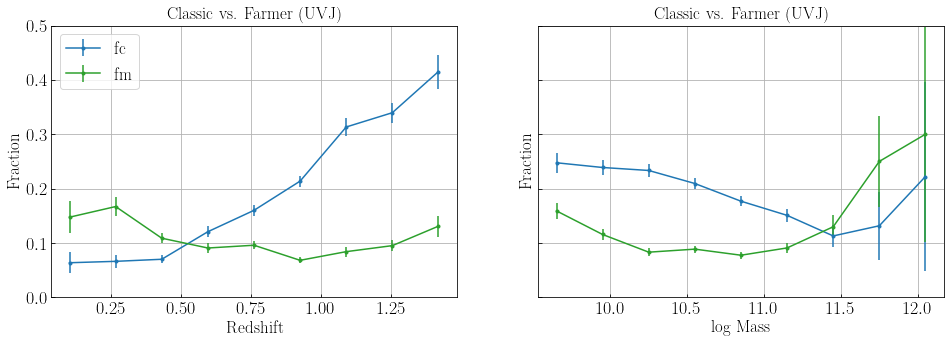

In [76]:
# classic vs farmer (ez,uvj)
 
q_labels = (cat_combine_c20_z['CLASS_UVJ_classic']==0).astype(int)
q = (cat_combine_c20_z['CLASS_UVJ_farmer']==0).astype(int)
sf = (cat_combine_c20_z['CLASS_UVJ_farmer']==1).astype(int)
    
true_q = q_labels==1
true_sf = q_labels==0

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

plot_fcfm(data, q_labels, q, sf,title='Classic vs. Farmer (UVJ)' )


fc=0.145 fm=0.349


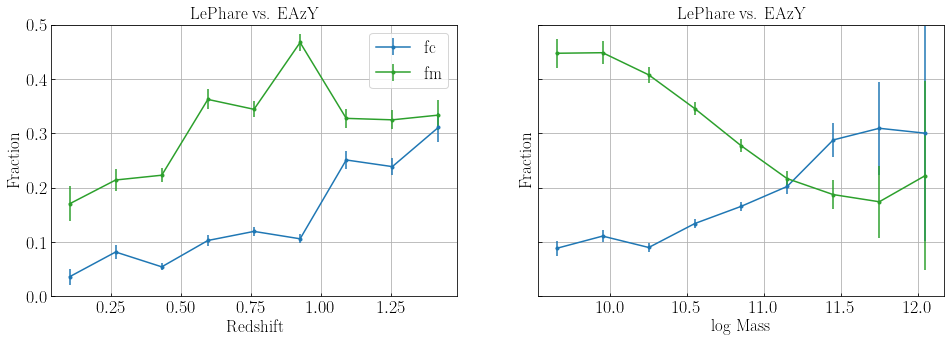

In [78]:
# lephare vs eazy (ssfr, farmer)

q_labels = np.array([0 for x in range(len(cat_combine_c20_z))])
q_labels[cat_combine_c20_z['lp_sSFR_med_farmer']<-11]=1
true_q = q_labels==1
true_sf = q_labels==0

q = (cat_combine_c20_z['ez_ssfr_p500_farmer']<-11.).astype(int)
sf = (cat_combine_c20_z['ez_ssfr_p500_farmer']>=-11.).astype(int)

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
plot_fcfm(data, q_labels, q, sf,title='LePhare vs. EAzY')
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

fc=0.145 fm=0.349


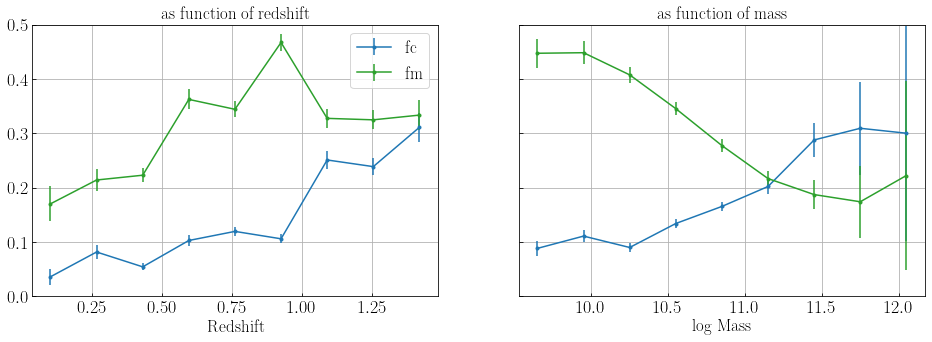

In [111]:
# lephare vs eazy (ssfr, farmer)

q_labels = np.array([0 for x in range(len(cat_combine_c20_z))])
q_labels[cat_combine_c20_z['lp_sSFR_med_farmer']<-11]=1
true_q = q_labels==1
true_sf = q_labels==0

q = (cat_combine_c20_z['ez_ssfr_p500_farmer']<-11.).astype(int)
sf = (cat_combine_c20_z['ez_ssfr_p500_farmer']>=-11.).astype(int)

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
plot_fcfm(data, q_labels, q, sf)
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

fc=0.063 fm=0.26
[ 9.5  9.8 10.1 10.4 10.7 11.  11.3 11.6 11.9 12.2]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


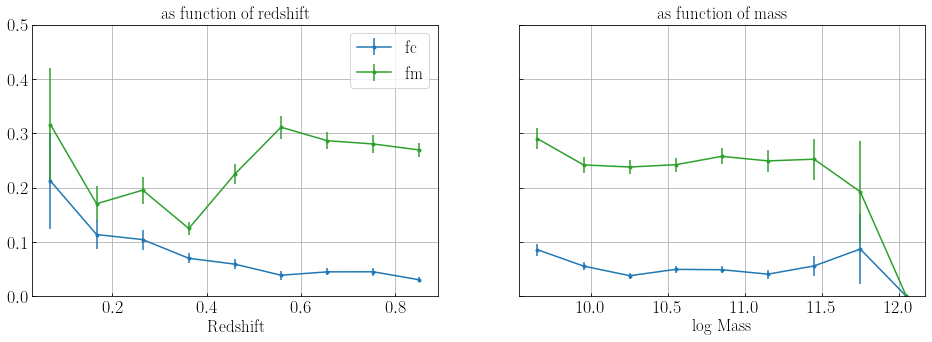

In [51]:
# lephare vs eazy (NUVrJ/UVJ, farmer)

q_labels = (cat_combine_c20_z['CLASS_farmer']==0).astype(int)
q = (cat_combine_c20_z['CLASS_UVJ_farmer']==0).astype(int)
sf = (cat_combine_c20_z['CLASS_UVJ_farmer']==1).astype(int)
true_q = q_labels==1
true_sf = q_labels==0

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

plot_fcfm(data, q_labels, q, sf)   
    

####
#### Compare my catalog to C20, minimizing cost function

In [36]:
# match my catalog with C20

cat_mycosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits'
cat_photoz_type = '11band'

# cat_mycosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_z6B_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits'
# cat_photoz_type = '6band'

if cat_photoz_type == '11band':
    photoz_type_show = ''
else:
    photoz_type_show = '_z6B'
    
cat_c20_name = '/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_FARMER_combine_v2.2.fits'
combined_cat_name = cat_mycosmos_name.replace('.fits','_c20added.fits')
print(combined_cat_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_c20added.fits


In [ ]:
cmd = 'java -jar stilts.jar tmatch2 matcher=sky+1d params="0.5 1"\
   in1='+cat_mycosmos_name + ' values1="RA DEC i" \
   in2='+cat_c20_name +' values2="ALPHA_J2000_farmer DELTA_J2000_farmer HSC_i_MAG" \
   out='+ combined_cat_name
# print(cmd)
os.system(cmd)

# remove unnecessary columns
cat_matched = Table.read(combined_cat_name)
for keyname in cat_matched.keys():
    if '_1' in keyname or 'Separation' in keyname:
        cat_matched.remove_column(keyname)
    elif '_2' in keyname:
        cat_matched.rename_column(keyname,keyname.replace('_2',''))
        
# add photometric flags
cat_matched = add_photo_flag(cat_matched,c20_zname='lp_zPDF_farmer',c20_massname='lp_mass_med_farmer')
cat_matched.write(cat_mycosmos_name.replace('.fits','_c20added.fits'), overwrite=True)
# print(cat_matched.keys())

In [37]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import time

In [38]:
# process table
print(cat_mycosmos_name.replace('.fits','_c20added.fits'))
cat = Table.read(cat_mycosmos_name.replace('.fits','_c20added.fits'))
cat = cat[(cat['lp_zPDF_farmer']>0) & (cat['lp_zPDF_farmer']<3)]
cat = cat[cat['inside_u'] == True]
cat = cat[cat['inside_hsc'] == True]
cat = cat[cat['isStar']==False]
cat = cat[cat['isCompact']==False]
cat = cat[cat['i_compact_flag']==False]
cat = cat[cat['snr_i']>3]
cat = cat[cat['snr_r']>1.5]
cat = cat[cat['snr_z']>1.5]
cat = cat[cat['i_cmodel']>0]
            
mkeyname = 'MASS_MED'
cat = cat[cat[mkeyname]>9.0]
cat = cat[cat[mkeyname]<11.8]
print(len(cat))

flag_photoz = cat['flag_photoz']>0
cat = cat[flag_photoz]  

# flags
flag_optical = cat['flag_optical'] 
flag_irac = cat['flag_irac'] 
flag_nir = cat['flag_nir'] 
cond_filters = (flag_optical>4) 
cat = cat[cond_filters]
cat = cat[cat['cmodel_fail_flag']==0]
# cut in redshift
cat_z = cat[(cat['Z_COMBINE']>0.1) & (cat['Z_COMBINE']<1.5)]
print(len(cat_z))

# remove fake massives
# flag_fakemassive = (((cat_z['Z_COMBINE']<0.5) & (cat_z[mkeyname]>10.0)) | ((cat_z['Z_COMBINE']<0.9) & (cat_z[mkeyname]>10.5))) & (cat_z['flag_irac'] <2)
# cat_z = cat_z[flag_fakemassive==False] # remove them
print(len(cat_z))

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_c20added.fits
231124
93893
93893


In [47]:
# input data
cat_z = cat_z['MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_Ks','Z_COMBINE',mkeyname,'CLASS_farmer','lp_zPDF_farmer','lp_mass_med_farmer','lp_sSFR_med_farmer','SSFR_MED','i','lp_MR','lp_MNUV','lp_MJ','lp_MK']
print(len(cat_z))

# resampling to remove z,M bias?

# data and reference labels
Mval = cat_z[mkeyname]
Zval = cat_z['Z_COMBINE']
NR, RK = (cat_z['MAG_ABS_NUV']-cat_z['MAG_ABS_r']), (cat_z['MAG_ABS_r']-cat_z['MAG_ABS_Ks'])
data = np.array([RK, NR, Zval, Mval]).T

ssfr_cut = -11
q_labels_ssfr = np.array([0 for x in range(len(cat_z))])
q_labels_ssfr[cat_z['lp_sSFR_med_farmer']<ssfr_cut]=1
q_labels_nuvrj = (cat_z['CLASS_farmer']==0).astype(int)

# Split the dataset into training and testing sets
training_ids = np.random.choice(np.arange(len(cat_z)), size=int(0.2*len(cat_z)), replace=False)
test_ids = np.ones(len(cat_z), np.bool)
test_ids[training_ids] = 0
cat_z_train,cat_z_test = cat_z[training_ids],cat_z[test_ids]
data_train, data_test = data[training_ids],data[test_ids]
q_labels_ssfr_train,q_labels_ssfr_test = q_labels_ssfr[training_ids],q_labels_ssfr[test_ids]
q_labels_nuvrj_train,q_labels_nuvrj_test = q_labels_nuvrj[training_ids],q_labels_nuvrj[test_ids]

# processing of train sample
cond_remove_gvgals = np.logical_or(cat_z_train['lp_sSFR_med_farmer']<=ssfr_cut-0.1,cat_z_train['lp_sSFR_med_farmer']>=ssfr_cut+0.1)
cat_z_train = cat_z_train[cond_remove_gvgals]
data_train = data_train[cond_remove_gvgals]
q_labels_ssfr_train = q_labels_ssfr_train[cond_remove_gvgals]
q_labels_nuvrj_train = q_labels_nuvrj_train[cond_remove_gvgals]
print('training sample size',len(cat_z_train))

# processing of test sample
# print(len(cat_z_test))
# cond_remove_gvgals = np.logical_or(cat_z_test['lp_sSFR_med']<=ssfr_cut-0.1,cat_z_test['lp_sSFR_med']>=ssfr_cut+0.1)
# cat_z_test = cat_z_test[cond_remove_gvgals]
# data_test = data_test[cond_remove_gvgals]
# q_labels_ssfr_test = q_labels_ssfr_test[cond_remove_gvgals]
# q_labels_nuvrj_test = q_labels_nuvrj_test[cond_remove_gvgals]
# print(len(cat_z_test))

c20_ref_type = 'ssfr'
if c20_ref_type == 'ssfr':
    q_labels_train = q_labels_ssfr_train
else:
    q_labels_train = q_labels_nuvrj_train
    
###### set r-fractor #######

r = 0.5 # r=2.5,r=1,r=0.5
print('r-fractor',r)

93893
training sample size 18557
r-fractor 0.5


##### run the optimizer

In [56]:
# run in 2d space
print(c20_ref_type,'r='+str(r))
initial_guess_2d = [4.0, 3.3, 1.4] # ic_1, ic_2, slope
bounds_2d = [(3.2,4.8),(1,5),(1,4)]

start = time.time()
# result = minimize(cost_function, x0=np.array(initial_guess_2d), args=(data_train, q_labels_train,'2d','fcfm'), method='Nelder-Mead',tol=0.001)
result = differential_evolution(cost_function, bounds=[(3,5),(1,4),(1,3)], args=(data_train,q_labels_train,'2d','fcfm',r),tol=0.001)
end = time.time()

print('length of table',len(cat_z),', elapsed time:',round(end - start,2))
print(result.x, round(result.fun,4))
best_params_2d = result.x
np.save('best_params_2d'+'_'+c20_ref_type+photoz_type_show+'_'+str(r)+'_z15', best_params_2d)

ssfr r=1.0
length of table 93893 , elapsed time: 0.34
[3.628 3.147 1.009] 0.2868


In [57]:
# run in 3d space
print(c20_ref_type,'r='+str(r))
initial_guess_3d = [4.0, 1.3, 2.4, 0.2] # ic_1, ic_2, slope, M_factor

start = time.time()
# result = minimize(cost_function, x0=np.array(initial_guess_3d), args=(data_train, q_labels_train,'3d','fcfm'), method='Nelder-Mead',tol=0.001)
result = differential_evolution(cost_function, bounds=[(3,5),(1,4),(1,3),(-0.5,0.5)], args=(data_train,q_labels_train,'3d','fcfm',r),tol=0.001)
end = time.time()

print('length of table',len(cat_z),', elapsed time:',round(end - start,2))
print(result.x, round(result.fun,4))
best_params_3d = result.x
np.save('best_params_3d'+'_'+c20_ref_type+photoz_type_show+'_'+str(r)+'_z15', best_params_3d)

ssfr r=1.0
length of table 93893 , elapsed time: 0.98
[3.626e+00 3.104e+00 1.011e+00 3.365e-03] 0.2877


In [58]:
# run in 4d space
print(c20_ref_type,'r='+str(r))
# initial_guess_4d = [3.98306183, 2.08429589, 0.72176767, -0.2066034, 0.1] # ic_1, ic_2, slope, z_factor, M_factor

# run the optimizer
for cost_func in ['ttff','fcfm']:
    start = time.time()
    # result = minimize(cost_function, x0=np.array(initial_guess_4d), args=(data_train, q_labels_train,'4d',cost_func), method='Nelder-Mead',tol=0.001)
    result = differential_evolution(cost_function, bounds=[(3.5,6),(1.5,4),(1,3),(-0.5,0.5),(-0.5,0.5)], args=(data_train,q_labels_train,'4d',cost_func,r),tol=0.001)
    end = time.time()

    print('length of table',len(cat_z),', elapsed time:',round(end - start,2))
    print(cost_func, result.x,'best score:',round(result.fun,3))
    best_params_4d = result.x
    np.save('best_params_4d'+'_'+c20_ref_type+photoz_type_show+'_'+cost_func+'_'+str(r)+'_z15', best_params_4d)

ssfr r=1.0
length of table 93893 , elapsed time: 0.88
ttff [ 3.773  2.962  1.009 -0.04   0.01 ] best score: -16017.461
length of table 93893 , elapsed time: 1.76
fcfm [3.783 2.754 1.006 0.055 0.004] best score: 0.285


In [73]:
# test different r's

for r in np.linspace(0.6,2.6,11):
    cost_func = 'fcfm'
    result = differential_evolution(cost_function, bounds=[(3.5,6),(1.5,4),(1,3),(-0.5,0.5),(-0.5,0.5)], args=(data_train,q_labels_train,'4d',cost_func,r),tol=0.0001)
    
    best_params_4d_test_r = result.x
    delta_boundary = data_test[:,1] - boundary_4d(data_test[:,0], best_params_4d_test_r[0], best_params_4d_test_r[1], best_params_4d_test_r[2],best_params_4d_test_r[3],best_params_4d_test_r[4],data_test[:,2],data_test[:,3])
    q = delta_boundary>0
    sf = delta_boundary<=0
    
    print('')
    for sfq in ['q','sf']:
        fc,fm = plot_fcfm(data_test, q_labels_ssfr_test, q, sf, '4d,ssfr,fcfm',eval_type=sfq,plot=False)
        print(round(r,1),sfq,'fc='+str(round(fc,3)),'fm='+str(round(fm,3)))


0.6 q fc=0.227 fm=0.133
0.6 sf fc=0.025 fm=0.046


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in long_scalars



0.8 q fc=0.17 fm=0.136
0.8 sf fc=0.025 fm=0.032

1.0 q fc=0.153 fm=0.148
1.0 sf fc=0.027 fm=0.028

1.2 q fc=0.138 fm=0.159
1.2 sf fc=0.029 fm=0.024

1.4 q fc=0.128 fm=0.165
1.4 sf fc=0.03 fm=0.022

1.6 q fc=0.123 fm=0.175
1.6 sf fc=0.031 fm=0.021

1.8 q fc=0.119 fm=0.182
1.8 sf fc=0.033 fm=0.02

2.0 q fc=0.111 fm=0.189
2.0 sf fc=0.034 fm=0.018

2.2 q fc=0.107 fm=0.197
2.2 sf fc=0.035 fm=0.017

2.4 q fc=0.108 fm=0.198
2.4 sf fc=0.035 fm=0.017

2.6 q fc=0.107 fm=0.207
2.6 sf fc=0.037 fm=0.017


##### 

#####
#### The Plots

##### contamination/missing fraction
as func. of redshift and mass

data columns:
1. r - K (0)
2. NUV - r (1)
3. z (2)
4. M (3)

#### Comparisons

(8, 12)

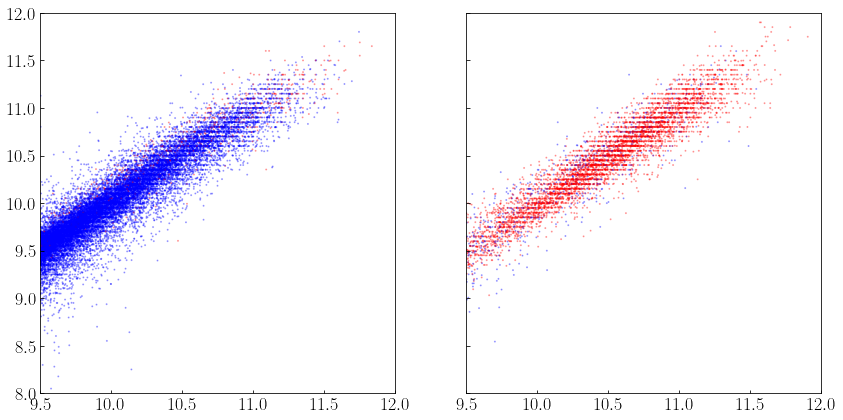

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (14, 7), sharey=True)

cat_z_sfc20 = cat_z[cat_z['lp_sSFR_med_farmer']>-11]
rk_sf = np.array(cat_z_sfc20['MAG_ABS_r'] - cat_z_sfc20['MAG_ABS_Ks'])
delta_gv_sf = cat_z_sfc20['MAG_ABS_NUV'] - cat_z_sfc20['MAG_ABS_r']-boundary_4d(rk_sf, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_z_sfc20['Z_COMBINE'], cat_z_sfc20['MASS_MED_massrun'])

axs[0].scatter(cat_z_sfc20['MASS_MED_massrun'],cat_z_sfc20['lp_mass_med_farmer'],s=1,c=delta_gv_sf>0,cmap='bwr',alpha=0.3)
axs[0].set_xlim([9.5,12])
axs[0].set_ylim([8,12])


cat_z_qc20 = cat_z[cat_z['lp_sSFR_med_farmer']<=-11]
rk_q = np.array(cat_z_qc20['MAG_ABS_r'] - cat_z_qc20['MAG_ABS_Ks'])
delta_gv_q = cat_z_qc20['MAG_ABS_NUV'] - cat_z_qc20['MAG_ABS_r']-boundary_4d(rk_q, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_z_qc20['Z_COMBINE'], cat_z_qc20['MASS_MED_massrun'])

axs[1].scatter(cat_z_qc20['MASS_MED_massrun'],cat_z_qc20['lp_mass_med_farmer'],s=1,c=delta_gv_q<0,cmap='bwr_r',alpha=0.3)
axs[1].set_xlim([9.5,12])
axs[1].set_ylim([8,12])


(1, 7)

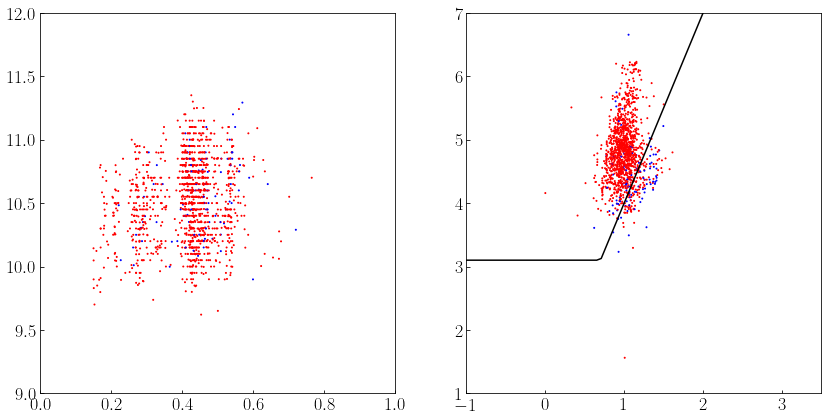

In [128]:
cat_zm_check = cat_z[(cat_z['Z_COMBINE']>0.2) & (cat_z['Z_COMBINE']<0.5)]
cat_zm_check = cat_zm_check[(cat_zm_check['MASS_MED_massrun']>10.0) & (cat_zm_check['MASS_MED_massrun']<11.0)]

cat_zm_check_c20q = cat_zm_check[cat_zm_check['lp_sSFR_med']<-11]
rk = np.array(cat_zm_check_c20q['MAG_ABS_r'] - cat_zm_check_c20q['MAG_ABS_Ks']) 
delta_gv = cat_zm_check_c20q['MAG_ABS_NUV'] - cat_zm_check_c20q['MAG_ABS_r']-boundary_4d(rk, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_zm_check_c20q['Z_COMBINE'], cat_zm_check_c20q['MASS_MED_massrun'])
q = delta_gv<0  # TN

fig, axs = plt.subplots(1, 2, figsize = (14, 7))

axs[0].scatter(cat_zm_check_c20q['lp_zPDF'], cat_zm_check_c20q['lp_mass_med'],s=1,c=q,cmap='bwr_r')
axs[0].set_xlim(0,1.0)
axs[0].set_ylim(9,12)

axs[1].scatter(cat_zm_check_c20q['lp_MR']-cat_zm_check_c20q['lp_MJ'],cat_zm_check_c20q['lp_MNUV']-cat_zm_check_c20q['lp_MR'],s=1,c=q,cmap='bwr_r')
rj_draw = np.linspace(-1,3.5,80)
nuv_draw_mid = boundary_basic(rj_draw, 3.1,1,3)
plt.plot(rj_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M),color='k')
axs[1].set_xlim(-1,3.5)
axs[1].set_ylim(1,7)

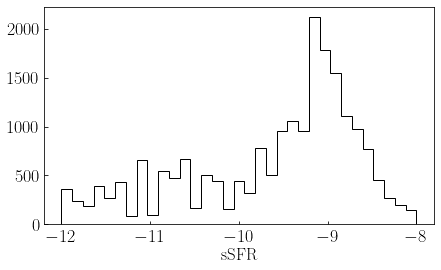

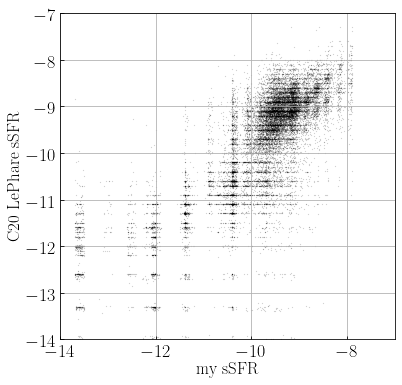

In [31]:
fig, axs = plt.subplots(1, 1, figsize = (7, 4), sharey=True)
plt.hist(cat_z['lp_sSFR_med'],range=(-12,-8), bins='scott',color='k',histtype='step')
plt.xlabel('sSFR',fontsize=17)
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (6, 6), sharey=True)
plt.scatter(cat_z['SSFR_MED'],cat_z['lp_sSFR_med'],s=0.03,alpha=0.4,color='k')
plt.xlabel('my sSFR',fontsize=17)
plt.ylabel('C20 LePhare sSFR',fontsize=17)
plt.xlim([-14,-7])
plt.ylim([-14,-7])
plt.grid()

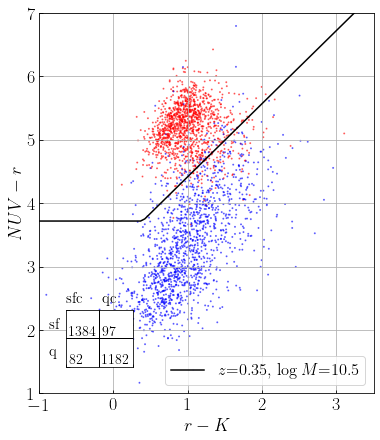

In [64]:
# NUVrK for galaxies 0.2<z<0.5,10.0<M<11.0

fig, axs = plt.subplots(1, 1, figsize = (6, 7), sharey=True)
rk_draw = np.linspace(-1,3.5,80)

M = 10.5
z = 0.35
nuv_draw_mid = boundary_4d(rk_draw, 3.718 , 2.83,   1.004, -0.204,  0.021, z, M)

# sample selection
cat_zm_check = cat_z[(cat_z['Z_COMBINE']>0.2) & (cat_z['Z_COMBINE']<0.5)]
cat_zm_check = cat_zm_check[(cat_zm_check['MASS_MED_massrun']>10.0) & (cat_zm_check['MASS_MED_massrun']<11.0)]

# draw
plt.scatter(cat_zm_check['MAG_ABS_r']-cat_zm_check['MAG_ABS_Ks'],cat_zm_check['MAG_ABS_NUV']-cat_zm_check['MAG_ABS_r'],c=cat_zm_check['lp_sSFR_med']>-11,s=1,alpha=0.5,cmap='bwr_r')
plt.plot(rk_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M),color='k')

#### contingency table / confusion matrix (inset plot 2) ######
# q=P sf=N
cat_sf = cat_zm_check[cat_zm_check['lp_sSFR_med']>-11]
cat_q = cat_zm_check[cat_zm_check['lp_sSFR_med']<=-11]
rk_sf = np.array(cat_sf['MAG_ABS_r'] - cat_sf['MAG_ABS_Ks'])
rk_q = np.array(cat_q['MAG_ABS_r'] - cat_q['MAG_ABS_Ks']) 
delta_gv_sf = cat_sf['MAG_ABS_NUV'] - cat_sf['MAG_ABS_r']-boundary_4d(rk_sf, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_sf['Z_COMBINE'], cat_sf['MASS_MED_massrun'])
delta_gv_q = cat_q['MAG_ABS_NUV'] - cat_q['MAG_ABS_r']-boundary_4d(rk_q, 3.718 , 2.83,   1.004, -0.204,  0.021, cat_q['Z_COMBINE'], cat_q['MASS_MED_massrun'])
# 3.435,  1.574,  1.185, -0.207,  0.021

# Me - C20
sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
q_q = len(cat_q[delta_gv_q>0])      # TP
sf_q = len(cat_q[delta_gv_q<0])     # FP
q_sf = len(cat_sf[delta_gv_sf>0])   # FN

f_c_sf = sf_q / (sf_q+sf_sf)
f_m_sf = q_sf / (sf_q+sf_sf)
f_c_q = q_sf / (q_q+q_sf)
f_m_q = sf_q / (q_q+q_sf)

# inset table
axs.annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
axs.annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
axs.annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
axs.annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
ax_insert2 = axs.inset_axes([0.08, 0.07, 0.2, 0.15])
ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
ax_insert2.set_xlim([-1,1])
ax_insert2.set_ylim([-1,1])
ax_insert2.set_yticklabels([])
ax_insert2.set_xticklabels([])
        
plt.xlabel('$r-K$',fontsize=18)
plt.ylabel('$NUV-r$',fontsize=18)
plt.xlim([-1,3.5])
plt.ylim([1,7])
plt.grid()
plt.legend(fontsize=16.5)

[ 9.5  9.8 10.1 10.4 10.7 11.  11.3 11.6 11.9 12.2]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars


(0.0662041625371655, 0.23286109754111708)

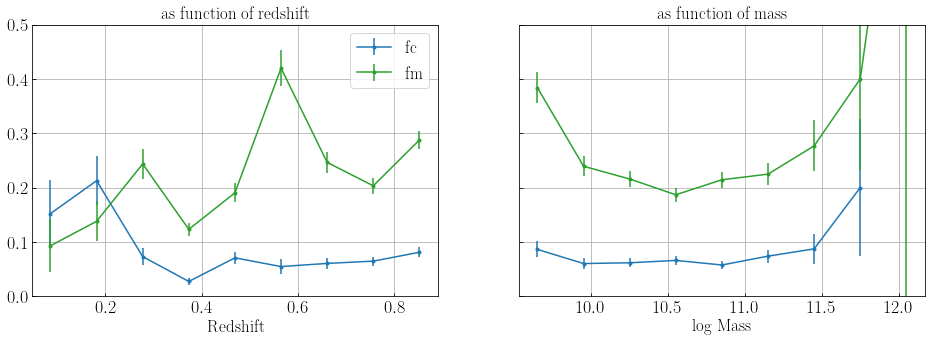

In [70]:
# my ssfr
q = cat_z['SSFR_MED']<-11
sf = cat_z['SSFR_MED']>=-11
plot_fcfm(data, q_labels_ssfr, q, sf)

ssfr 
[ 3.834  3.385  1.143 -0.123 -0.009] 1.0
[ 3.752e+00  2.358e+00  1.361e+00 -2.440e-01  2.389e-03] 1.0


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in long_scalars


fc=0.188 fm=0.138


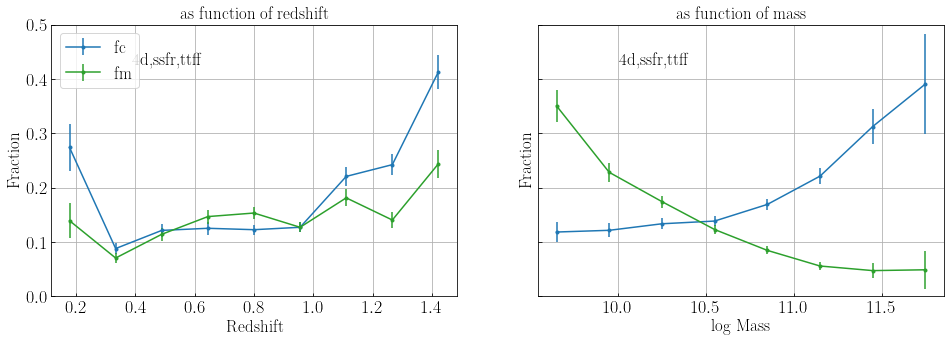

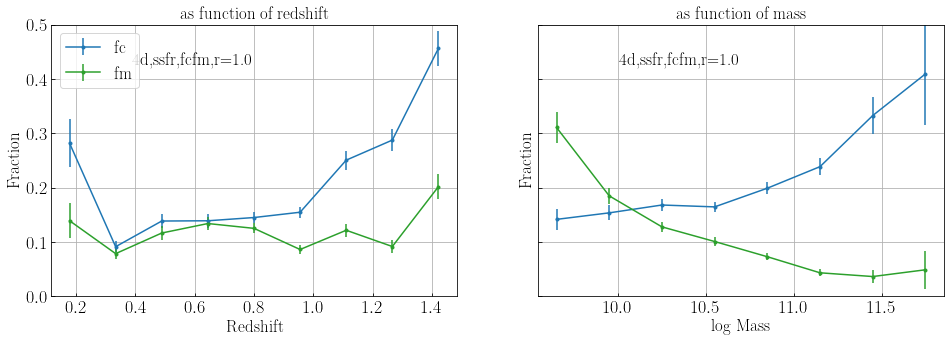

In [55]:
# ttff (Angelo's method) vs fcfm (4D, ssfr)
c20_ref_type = 'ssfr'
print(c20_ref_type,photoz_type_show)

r=1.0
params_ssfr_ttff = np.load('best_params_4d_ssfr'+photoz_type_show+'_ttff'+'_'+str(r)+'.npy')
params_ssfr_fcfm = np.load('best_params_4d_ssfr'+photoz_type_show+'_fcfm'+'_'+str(r)+'.npy')
# params_ssfr_fcfm  = np.array([3.435,  1.574,  1.185, -0.207,  0.021])
print(params_ssfr_ttff,r)
print(params_ssfr_fcfm,r)

delta_boundary = data_test[:,1] - boundary_4d(data_test[:,0], params_ssfr_ttff[0], params_ssfr_ttff[1], params_ssfr_ttff[2],params_ssfr_ttff[3],params_ssfr_ttff[4],data_test[:,2],data_test[:,3])
q = delta_boundary>0
sf = delta_boundary<=0
fc,fm = plot_fcfm(data_test, q_labels_ssfr_test, q, sf, '4d,ssfr,ttff')
plt.plot()

delta_boundary = data_test[:,1] - boundary_4d(data_test[:,0], params_ssfr_fcfm[0], params_ssfr_fcfm[1], params_ssfr_fcfm[2],params_ssfr_fcfm[3],params_ssfr_fcfm[4],data_test[:,2],data_test[:,3])
q = delta_boundary>0
sf = delta_boundary<=0
fc,fm = plot_fcfm(data_test, q_labels_ssfr_test, q, sf, '4d,ssfr,fcfm,r='+str(r))
print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))

[3.796 3.066 1.052]
[ 3.752e+00  2.358e+00  1.361e+00 -2.440e-01  2.389e-03]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in long_scalars


(0.14320181663355094, 0.16971530738550406)

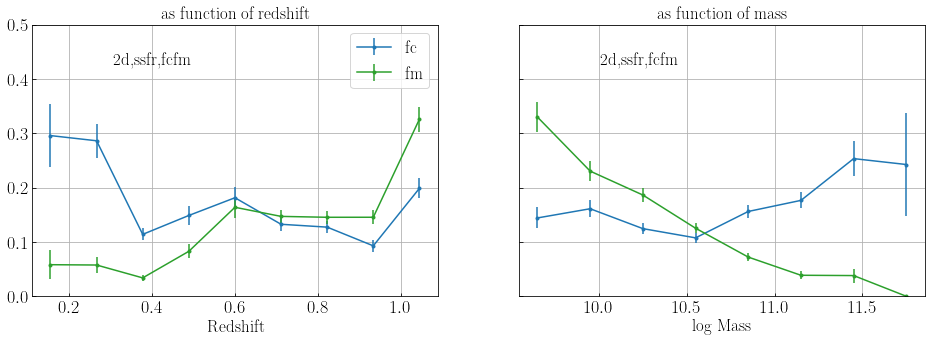

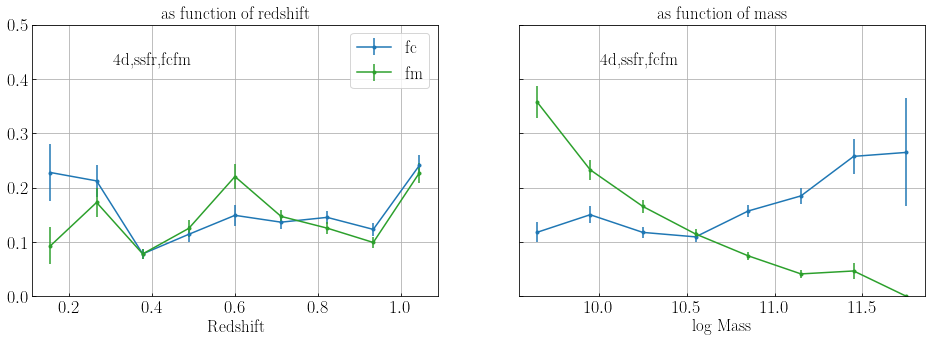

In [62]:
# 2d vs 4d (ssfr, fcfm)

params_2d = np.load('best_params_2d_ssfr'+'_'+str(r)+'.npy')
params_4d = np.load('best_params_4d_ssfr_fcfm'+'_'+str(r)+'.npy')
print(params_2d)
print(params_4d)

delta_boundary = data_test[:,1] - boundary_basic(data_test[:,0], params_2d[0], params_2d[1], params_2d[2])
q = delta_boundary>0
sf = delta_boundary<=0
plot_fcfm(data_test,q_labels_ssfr_test,q,sf,'2d,ssfr,fcfm')

delta_boundary = data_test[:,1] - boundary_4d(data_test[:,0], params_4d[0], params_4d[1], params_4d[2],params_4d[3],params_4d[4],data_test[:,2],data_test[:,3])
q = delta_boundary>0
sf = delta_boundary<=0
plot_fcfm(data_test,q_labels_ssfr_test,q,sf,'4d,ssfr,fcfm')


[ 3.86   3.425  1.136 -0.034]
[ 4.252  2.11   1.217 -0.309  0.064]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in long_scalars


(0.04405286343612335, 0.5864303411473223)

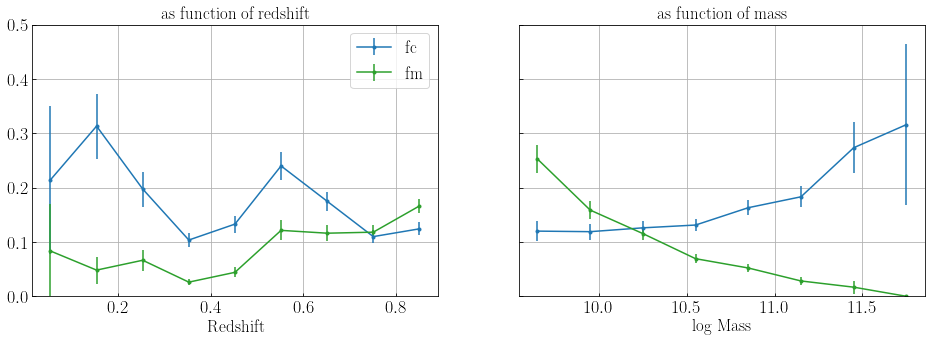

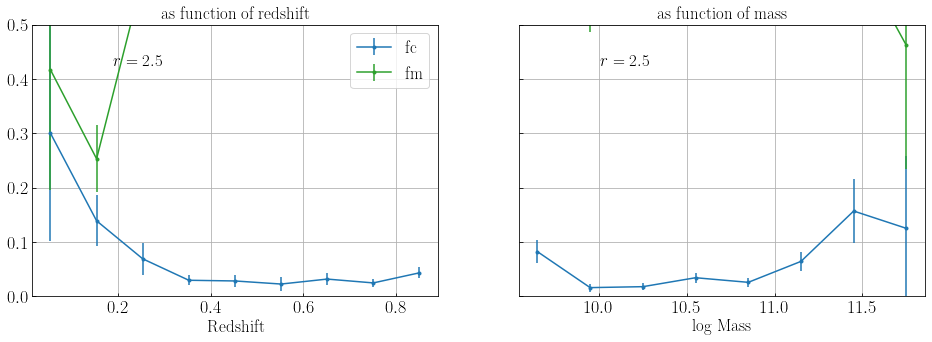

In [68]:
# 3d vs 4d (ssfr, fcfm)

params_3d = np.load('best_params_3d_ssfr.npy')
params_4d = np.load('best_params_4d_ssfr_fcfm.npy')
print(params_3d)
print(params_4d)

delta_boundary = data_test[:,1] - boundary_3d(data_test[:,0], params_3d[0], params_3d[1], params_3d[2], params_3d[3],data_test[:,3])
q = delta_boundary>0
sf = delta_boundary<=0
plot_fcfm(data_test,q_labels_ssfr_test,q,sf)

delta_boundary = data_test[:,1] - boundary_4d(data_test[:,0], params_4d[0], params_4d[1], params_4d[2],params_4d[3],params_4d[4],data_test[:,2],data_test[:,3])
q = delta_boundary>0
sf = delta_boundary<=0
plot_fcfm(data_test,q_labels_ssfr_test,q,sf, '$r='+str(r_factor)+'$')



#### check missing low-mass quiescent galaxies

0.034 0.49
527
489


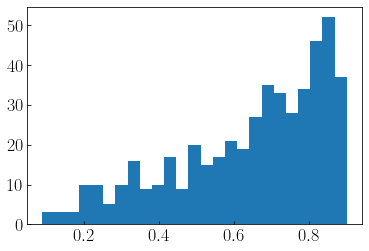

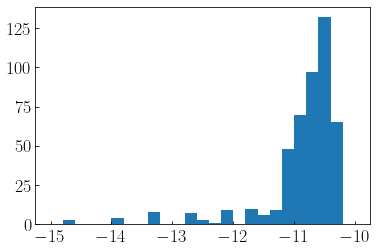

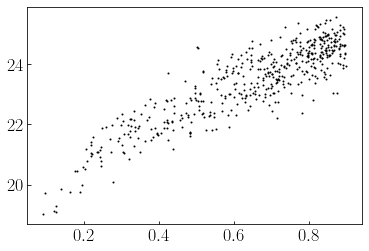

In [17]:
cat_z_lowm = cat_z[cat_z['MASS_MED_massrun']<9.8]
Mval = cat_z_lowm['MASS_MED_massrun']
Zval = cat_z_lowm['Z_COMBINE']
NR, RK = (cat_z_lowm['MAG_ABS_NUV']-cat_z_lowm['MAG_ABS_r']), (cat_z_lowm['MAG_ABS_r']-cat_z_lowm['MAG_ABS_Ks'])
data_lowm = np.array([RK, NR, Zval, Mval]).T

q_labels_ssfr = np.array([0 for x in range(len(cat_z_lowm))])
q_labels_ssfr[cat_z_lowm['lp_sSFR_med']<-10.3]=1
true_q = q_labels_ssfr == 1
true_sf = q_labels_ssfr == 0

params_ssfr_fcfm = np.load('best_params_4d_ssfr_fcfm.npy')
delta_boundary = data_lowm[:,1] - boundary_4d(data_lowm[:,0], params_ssfr_fcfm[0], params_ssfr_fcfm[1], params_ssfr_fcfm[2],params_ssfr_fcfm[3],params_ssfr_fcfm[4],data_lowm[:,2],data_lowm[:,3])
q = delta_boundary>0
sf = delta_boundary<=0

fc,fm = fc_fm(q, sf, true_q, true_sf, eval_type='q')
print(round(fc,3),round(fm,3))

cat_z_lowm_q = cat_z_lowm[q]
print(len(cat_z_lowm_q))

cat_z_lowm_q_missing = cat_z_lowm[sf & q_labels_ssfr==1]
print(len(cat_z_lowm_q_missing))

# plot
fig, axs = plt.subplots(1, 1, figsize = (6, 4), sharey=True)
plt.hist(cat_z_lowm_q_missing['Z_COMBINE'],bins=25)

fig, axs = plt.subplots(1, 1, figsize = (6, 4), sharey=True)
plt.hist(cat_z_lowm_q_missing['lp_sSFR_med'],bins=25,range=(-15,-10))
plt.show()

fig, axs = plt.subplots(1, 1, figsize = (6, 4), sharey=True)
plt.scatter(cat_z_lowm_q_missing['Z_COMBINE'],cat_z_lowm_q_missing['i'],s=1,color='k')
plt.show()

#### sf/q classification in 4 redshift bins
r factor

In [13]:
# process table
cat_name = cat_mycosmos_name.replace('.fits','_c20added.fits')
print(cat_name)
cat = Table.read(cat_name)
cat = cat[(cat['lp_zPDF_farmer']>0) & (cat['lp_zPDF_farmer']<3)]

cat = cat[cat['MASS_MED']>9.0]
cat = cat[cat['MASS_MED']<11.8]
print(len(cat))

flag_photoz = cat['flag_photoz']>0
cat = cat[flag_photoz]  

# flags
flag_optical = cat['flag_optical'] 
flag_irac = cat['flag_irac'] 
flag_nir = cat['flag_nir'] 
cond_filters = (flag_optical>4) #& (flag_irac>=1)
cat = cat[cond_filters]

# remove fake massives
flag_fakemassive = (((cat['Z_COMBINE']<0.5) & (cat['MASS_MED']>10.0)) | ((cat['Z_COMBINE']<0.9) & (cat['MASS_MED']>10.5))) & (cat['flag_irac'] <2)
cat = cat[flag_fakemassive==False] # remove them
print(len(cat))

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_new/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_c20added.fits
242534
167777


number of gals: 10449


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in long_scalars
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in long_scalars


fc=0.114 fm=0.062
[ 3.932  3.294  1.    -0.395  0.013] best_params_4d_ssfr_fcfm_0.55_0.2_0.5
number of gals: 21175
fc=0.217 fm=0.119
[ 3.699  2.423  1.    -0.497  0.043] best_params_4d_ssfr_fcfm_0.55_0.5_0.8
number of gals: 28588
fc=0.208 fm=0.104
[ 3.717  1.875  1.001 -0.08   0.034] best_params_4d_ssfr_fcfm_0.5_0.8_1.1
number of gals: 34331
fc=0.29 fm=0.13
[ 3.705  3.575  1.001  0.258 -0.046] best_params_4d_ssfr_fcfm_0.45_1.1_1.5


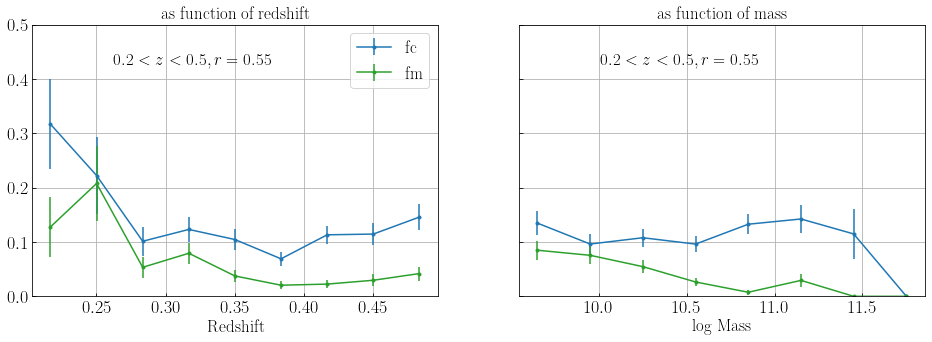

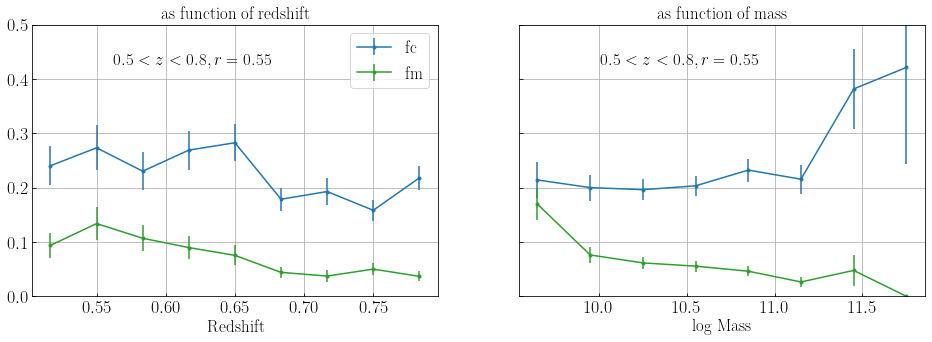

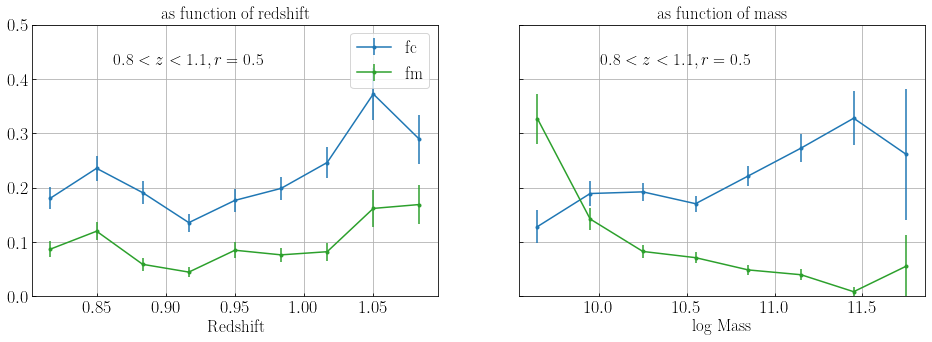

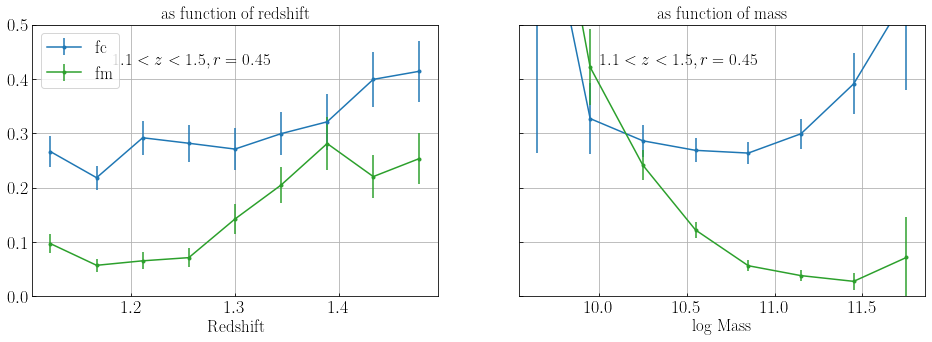

In [24]:
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

sfq_type = 'fm_weighted'
r_factors_base = np.array([1.1,1.1,1.0,0.9])
if sfq_type == 'fc_weighted':
    r_factors = r_factors_base*2.5
elif sfq_type == 'fm_weighted':
    r_factors = r_factors_base/2
elif sfq_type == 'balanced':
    r_factors = r_factors_base
else:
    raise NameError('wrong sfq type')

cost_func = 'fcfm'
c20_ref_type = 'ssfr'
for z_idx in range(len(z_mins)):
    # cut in redshift
    r_factor = r_factors[z_idx]
    cat_z = cat[(cat['Z_COMBINE']>z_mins[z_idx]) & (cat['Z_COMBINE']<z_maxs[z_idx])]
    
    # input data
    cat_z = cat_z['MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_Ks','Z_COMBINE','MASS_MED','CLASS_farmer','lp_zPDF_farmer','lp_mass_med_farmer','lp_sSFR_med_farmer','SSFR_MED','i','lp_MR','lp_MNUV','lp_MJ','lp_MK']
    
    ssfr_cut = -11
    cond_remove_gvgals = np.logical_or(cat_z_test['lp_sSFR_med_farmer']<=ssfr_cut-0.1,cat_z_test['lp_sSFR_med_farmer']>=ssfr_cut+0.1)
    cat_z_test = cat_z_test[cond_remove_gvgals]
    print('number of gals:',len(cat_z))
    
    # data and reference labels
    Mval = cat_z['MASS_MED']
    Zval = cat_z['Z_COMBINE']
    NR, RK = (cat_z['MAG_ABS_NUV']-cat_z['MAG_ABS_r']), (cat_z['MAG_ABS_r']-cat_z['MAG_ABS_Ks'])
    data = np.array([RK, NR, Zval, Mval]).T
    
    q_labels_ssfr = np.array([0 for x in range(len(cat_z))])
    q_labels_ssfr[cat_z['lp_sSFR_med_farmer']<ssfr_cut]=1
    
    result = differential_evolution(cost_function, bounds=[(3.5,6),(1.5,4),(1,3),(-0.5,0.5),(-0.5,0.5)], args=(data,q_labels_ssfr,'4d',cost_func,r_factor),tol=0.001)
    best_params_4d = result.x
    
    delta_boundary = data[:,1] - boundary_4d(data[:,0], best_params_4d[0], best_params_4d[1], best_params_4d[2],best_params_4d[3],best_params_4d[4],data[:,2],data[:,3])
    q = delta_boundary>0
    sf = delta_boundary<=0
    fc,fm=plot_fcfm(data,q_labels_ssfr,q,sf, '$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+',r='+str(r_factor)+'$')
    print('fc='+str(round(fc,3)),'fm='+str(round(fm,3)))
    
    result_name = 'best_params_4d'+'_'+c20_ref_type+photoz_type_show+'_'+cost_func+'_'+str(r_factor)+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])
    print(best_params_4d,result_name)
    np.save(result_name, best_params_4d)
    

In [8]:
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

sfq_type = 'fm_weighted'
r_factors_base = np.array([1.1,1.1,1.0,0.9])
if sfq_type == 'fc_weighted':
    r_factors = r_factors_base*2.5
elif sfq_type == 'fm_weighted':
    r_factors = r_factors_base/2
elif sfq_type == 'balanced':
    r_factors = r_factors_base
else:
    raise NameError('wrong sfq type')

cost_func = 'fcfm'
c20_ref_type = 'ssfr'

for z_idx in range(len(z_mins)):
    r_factor = r_factors[z_idx]
    result_name = 'best_params_4d'+'_'+c20_ref_type+'_'+cost_func+'_'+str(r_factor)+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])
    result = np.load(result_name+'.npy')
    print(result)

[ 3.903  3.195  1.079 -0.455  0.01 ]
[ 3.685  3.198  1.    -0.286  0.011]
[ 3.712  2.108  1.003 -0.159  0.033]
[ 3.66   2.904  1.012  0.46  -0.058]


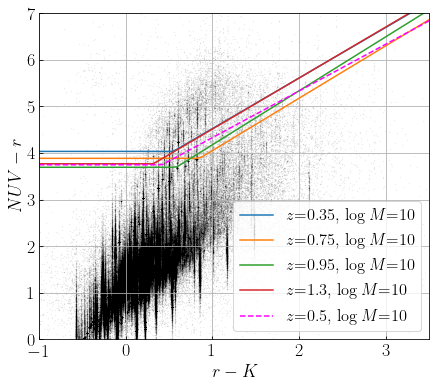

In [302]:

fig, axs = plt.subplots(1, 1, figsize = (7, 6), sharey=True)
rk_draw = np.linspace(-1,3.5,80)

cat_central_cosmos_name = '/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits'
cat_central_cosmos = Table.read(cat_central_cosmos_name)
axs.scatter(cat_central_cosmos['MAG_ABS_r']-cat_central_cosmos['MAG_ABS_Ks'],cat_central_cosmos['MAG_ABS_NUV']-cat_central_cosmos['MAG_ABS_r'],alpha=0.1,s=0.1,color='k')

M = 10
for z_idx,z in enumerate([0.35,0.75,0.95,1.3]):
    params_4d = np.load('best_params_4d_ssfr_fcfm_r_medium_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.npy')
    nuv_draw_mid = boundary_4d(rk_draw, params_4d[0], params_4d[1], params_4d[2],params_4d[3],params_4d[4], z, M)
    axs.plot(rk_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M))


M=10; z=0.5
params_4d = np.load('best_params_4d_ssfr_fcfm.npy')
nuv_draw_mid = boundary_4d(rk_draw, params_4d[0], params_4d[1], params_4d[2],params_4d[3],params_4d[4], z, M)
axs.plot(rk_draw, nuv_draw_mid,label='$z$='+str(z)+', $\log M$='+str(M),color='magenta',linestyle='--')
    
axs.set_xlabel('$r-K$',fontsize=18)
axs.set_ylabel('$NUV-r$',fontsize=18)
axs.set_xlim([-1,3.5])
axs.set_ylim([0,7])
axs.grid()
axs.legend(fontsize=16.5)


#### Angelo's code

In [36]:
def NUVrK_est(cat):
    mname = 'MASS_MED_massrun'
    zname = 'Z_COMBINE'
    catax = cat[(cat[zname]>0.1)&(cat[zname]<0.9)&(cat[mname]>9.5)]
    Mval = catax[mname]
    Zval = catax[zname]
    
    # fitting data and reference labels
    NR, RK = (catax['MAG_ABS_NUV']-catax['MAG_ABS_r']), (catax['MAG_ABS_r']-catax['MAG_ABS_Ks'])
    X = np.array([RK, NR, Zval, Mval]).T
    y = np.array([0 for x in range(len(catax))])
    y[catax['lp_sSFR_med']<-11]=1

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random.randint(0, 10000))

    # Define the separation condition function
    def separation_condition(coefficients, X, y):
        ic_1, ic_2, slope, z_factor, M_factor = coefficients
        rK, Nr, Zval, Mval = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
        y_pred = (Nr > ((slope + z_factor * Zval + M_factor * Mval) * (rK + ic_2))) & (Nr > ic_1)
        
        true_positives = np.sum((y_pred == 1) & (y == 1))
        true_negatives = np.sum((y_pred == 0) & (y == 0))
        false_positives = np.sum((y_pred == 1) & (y == 0))
        false_negatives = np.sum((y_pred == 0) & (y == 1))

        return -(0.5*true_positives + 0.5*true_negatives - 1.5*false_positives - 1*false_negatives)
    
    def cost_function_backup(params, data, q_labels, eval_type='q'):
        color1 = data[:,0] # r-K
        color2 = data[:,1] # NUV-r
        zVal = data[:,2]
        MVal = data[:,3]
        ic_1, ic_2, slope, z_factor, M_factor = params
        
        delta_boundary = color2 - np.maximum(ic_1, (slope + z_factor*zVal + M_factor * MVal) * (color1 + ic_2))
        q = delta_boundary > 0 # binary list, above boundary flags
        sf = delta_boundary <= 0 # binary list, below boundary flags
        
        true_q = q_labels==1 
        true_sf = q_labels==0

        FP = sum(true_sf*q)  # false positive
        TP = sum(true_q*q)   # true positive
        FN = sum(true_q*sf)  # false negative
        TN = sum(true_sf*sf) # true negative

        # calculate the cost function
        score = -(0.5*TP + 0.5*TN - 1.5*FP - 1*FN)  
        return score

    # Initial guess for the coefficients
    initial_guess = [4.2, -3.0, 3.2, -0.6, 0.2]

    
    # Minimize the separation condition function
    result = minimize(separation_condition, initial_guess, args=(X_train, y_train), method='Nelder-Mead')
    coefficients = result.x  # Extract optimized coefficients
    print(coefficients,round(result.fun,3))
    
    result = minimize(cost_function_backup, initial_guess, args=(X_train, y_train), method='Nelder-Mead')
    coefficients = result.x  # Extract optimized coefficients
    print(coefficients,round(result.fun,3))
    
    # return coefficients

NUVrK_est(cat_z)

NameError: name 'cat_z' is not defined

In [306]:
import numpy as np
import timeit

# x = list(range(1000))
# or 
x = np.random.standard_normal(1000)
print(type(x))

def pure_sum():
    return sum(x)

def numpy_sum():
    return np.sum(x)

n = 10000

t1 = timeit.timeit(pure_sum, number = n)
print('Pure Python Sum:', t1)
t2 = timeit.timeit(numpy_sum, number = n)
print('Numpy Sum:', t2)

<class 'numpy.ndarray'>
Pure Python Sum: 1.6301131780201104
Numpy Sum: 0.04894714101101272
